# Predição de ativos da bolsa de valores

# Importa as bibliotecas

In [83]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.offline import plot
import plotly.graph_objects as go

import datetime
from pmdarima.arima import auto_arima # biblioteca que importa o arima
import pmdarima.arima as pm # biblioteca que importa o arima
import statsmodels
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error
import pandas as pd

from pandas_datareader import data 
import yfinance as yfin
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


In [84]:
from statsmodels.tsa.arima.model import ARIMA
import xgboost as xgb
import tensorflow as tf

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv1D, LSTM, MaxPooling1D, AveragePooling1D, BatchNormalization, Flatten, Dropout, SpatialDropout1D, GRU, GlobalAveragePooling1D
from tensorflow.keras import Input

## Análise e visualização de ativos

### Carrega Dados

In [85]:
yfin.pdr_override()

acoes=['B3SA3','PETR4','KLBN11']
peso_acoes=np.ones(len(acoes))*1/len(acoes)
# adc o .SA no nome de cada ação para carregar no banco de dados
for i in range(np.size(acoes)):
    acoes[i]=acoes[i]+".SA"

acoes.append('^BVSP') # inclui o índice ibovespa na ultima coluna

acoes_df = pd.DataFrame() 
for acao in acoes:
     acoes_df[acao] = data.DataReader(acao, start='2010-01-01')['Close']

# substitui o .SA do nome de cada ação para visualização dos dados
for i in range(np.size(acoes)):
    acoes_df = acoes_df.rename(columns={acoes[i]:acoes[i].replace('.SA', '')})

#renomeia o índice IBOVESPA para IBOV   
acoes_df = acoes_df.rename(columns={acoes[i]:acoes[i].replace('^BVSP', 'IBOV')})
                           
#soma todos os valores nulos
acoes_df.isnull().sum()

#Verifica como está o shape do dataframe
acoes_df.shape
 


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


(3510, 4)

<Axes: ylabel='Date'>

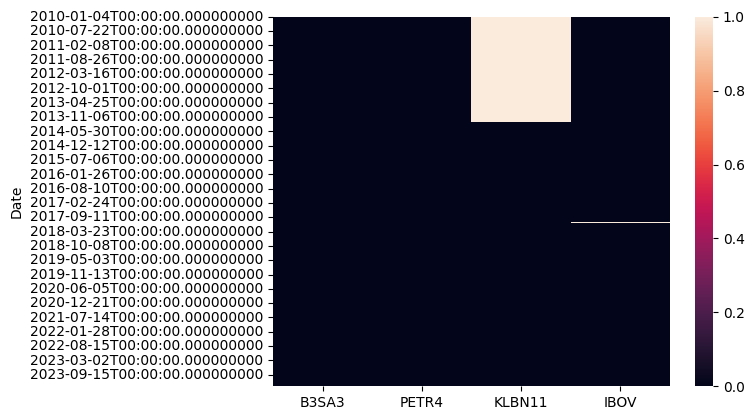

In [86]:
sns.heatmap(acoes_df.isnull())

In [87]:
#apaga registros nulos
acoes_df.dropna(inplace=True)
acoes_df.to_csv('acoes.csv')
acoes_df

,B3SA3,PETR4,KLBN11,IBOV
Date,,,,
2014-01-23,3.250000,15.470000,11.744000,48321.0
2014-01-24,3.233333,15.100000,11.744000,47787.0
2014-01-27,3.300000,15.110000,11.744000,47701.0
2014-01-28,3.280000,15.050000,12.586000,47841.0
2014-01-29,3.170000,14.800000,12.350000,47557.0
...,...,...,...,...
2024-02-21,12.810000,42.509998,21.660000,130032.0
2024-02-22,12.650000,42.189999,21.889999,130241.0
2024-02-23,12.450000,41.900002,21.680000,129419.0


### Visualização dos dados 

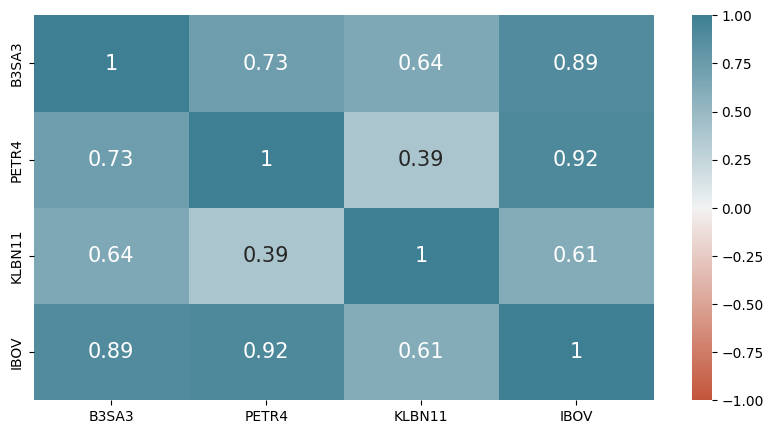

In [88]:
fig, axes = plt.subplots(1, 1, figsize=(10,5))

columns=acoes_df.columns
corrmat = acoes_df[columns].corr()
mask= np.zeros_like(corrmat)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corrmat,
            vmax=1, vmin=-1,
            annot=True, annot_kws={'fontsize':15},
            cmap=sns.diverging_palette(20,220,as_cmap=True))
plt.show()

In [89]:
# Normaliza os dados
acoes_df_normalized = acoes_df / acoes_df.iloc[0].values

In [90]:
acoes_df_normalized

,B3SA3,PETR4,KLBN11,IBOV
Date,,,,
2014-01-23,1.000000,1.000000,1.000000,1.000000
2014-01-24,0.994872,0.976083,1.000000,0.988949
2014-01-27,1.015385,0.976729,1.000000,0.987169
2014-01-28,1.009231,0.972851,1.071696,0.990066
2014-01-29,0.975385,0.956690,1.051601,0.984189
...,...,...,...,...
2024-02-21,3.941539,2.747899,1.844346,2.691004
2024-02-22,3.892308,2.727214,1.863930,2.695329
2024-02-23,3.830769,2.708468,1.846049,2.678318


In [91]:
#%% Carregando dados
acoes_df=pd.read_csv('acoes.csv')
acoes_df['Date']=pd.to_datetime(acoes_df['Date'])
acoes_df=acoes_df.set_index('Date')
for col in acoes_df.columns:
    acoes_df[col]=acoes_df[col].astype('float32')

In [92]:
acoes_df_normalized = acoes_df / acoes_df.iloc[0].values

In [93]:
# Cria um gráfico de linha usando o Plotly
fig = go.Figure()
for acoes in acoes_df.columns:
#fig.add_trace(go.Scatter(x=acoes_df.index, y=acoes_df['IBOV'], mode='lines', name='Preço do Ibovespa'))
#fig.add_trace(go.Scatter(x=acoes_df.index, y=acoes_df['B3SA3'], mode='lines', name='Preço do B3SA3'))
    fig.add_trace(go.Scatter(x=acoes_df_normalized.index, y=acoes_df_normalized[acoes], mode='lines', name=f'Preço do {acoes}'))

# Configura o layout do gráfico
fig.update_layout(
    title='Preço do Ibovespa e ações',
    xaxis_title='Data',
    yaxis_title='Preço',
    showlegend=True
)

# Exibe o gráfico
fig.show()

## Indicadores de tendência e Séries Temporais 

Os swing traders geralmente utilizam médias móveis exponenciais (EMAs) de diferentes períodos para identificar tendências e sinais de compra e venda. As EMAs mais utilizadas pelos swing traders incluem:

-EMA de 9 períodos: A EMA de 9 períodos é comumente usada para identificar sinais de curto prazo e capturar movimentos rápidos do mercado. Pode fornecer sinais mais sensíveis e frequentes.

-EMA de 20 períodos: A EMA de 20 períodos é amplamente utilizada e considerada uma média móvel de curto prazo. É usada para identificar a direção da tendência de curto prazo e possíveis pontos de reversão.

-EMA de 50 períodos: A EMA de 50 períodos é frequentemente usada para identificar a direção da tendência de médio prazo. É uma média móvel amplamente observada pelos swing traders.

-EMA de 100 períodos: A EMA de 100 períodos é usada para identificar a direção da tendência de médio a longo prazo. É útil para identificar pontos de entrada e saída em operações de swing trading mais prolongadas.

-EMA de 200 períodos: A EMA de 200 períodos é uma das médias móveis mais amplamente observadas e é usada para identificar a direção da tendência de longo prazo. É frequentemente usada como um indicador-chave para determinar a tendência geral do mercado.

In [94]:
acoes_df = acoes_df.rename(columns={acoes[i]:acoes[i].replace('^BVSP', 'IBOV')})


In [95]:
import pandas as pd
import pandas_datareader as pdr
import datetime
import plotly.graph_objects as go

# Define o código de ticker da ação
ticker = "^BVSP"

# Obtém os dados históricos da ação
df = data.DataReader(ticker, start='2015-01-01')

# Calcula as EMAs de 9 e 20 períodos
df['EMA9'] = df['Close'].ewm(span=9).mean()
df['EMA20'] = df['Close'].ewm(span=20).mean()
df['EMA50'] = df['Close'].ewm(span=50).mean()
df['EMA100'] = df['Close'].ewm(span=100).mean()
df['EMA200'] = df['Close'].ewm(span=200).mean()

# Cria um gráfico de candlestick usando o Plotly
fig = go.Figure(data=[go.Candlestick(x=df.index,
                open=df['Open'],
                high=df['High'],
                low=df['Low'],
                close=df['Close'],
                name='Candlestick')])

# Adiciona as médias móveis ao gráfico
fig.add_trace(go.Scatter(x=df.index, y=df['EMA9'], mode='lines', name='EMA9'))
fig.add_trace(go.Scatter(x=df.index, y=df['EMA20'], mode='lines', name='EMA20'))
fig.add_trace(go.Scatter(x=df.index, y=df['EMA50'], mode='lines', name='EMA50'))
fig.add_trace(go.Scatter(x=df.index, y=df['EMA100'], mode='lines', name='EMA100'))
fig.add_trace(go.Scatter(x=df.index, y=df['EMA200'], mode='lines', name='EMA200'))

if ticker=="^BVSP":
    ticker='IBOV'
# Configura o layout do gráfico
fig.update_layout(
    width=1500,
    height=700,
    title=f"Gráfico de Candlestick e Médias Móveis para {ticker}",
    xaxis_title="Data",
    yaxis_title="Preço",
    showlegend=True
)

# Exibe o gráfico
fig.show()


[*********************100%%**********************]  1 of 1 completed


In [96]:
df.index

DatetimeIndex(['2015-01-02', '2015-01-05', '2015-01-06', '2015-01-07',
               '2015-01-08', '2015-01-09', '2015-01-12', '2015-01-13',
               '2015-01-14', '2015-01-15',
               ...
               '2024-02-14', '2024-02-15', '2024-02-16', '2024-02-19',
               '2024-02-20', '2024-02-21', '2024-02-22', '2024-02-23',
               '2024-02-26', '2024-02-27'],
              dtype='datetime64[ns]', name='Date', length=2267, freq=None)

In [97]:
# Calcular a variação percentual entre o preço de fechamento de um dia e o dia seguinte
df['Variacao'] = ((df['Close'].shift(-7) - df['Close']) / df['Close'])*100

# Definir a variável alvo com base na variação percentual
df['Subida'] = df['Variacao'].apply(lambda x: 1 if x > 1 else 0)

#df['week']=df.index.week
df['weekday']=df.index.weekday+1
df['day']=df.index.day
df['month']=df.index.month
df['quarter']=df.index.quarter

df=df.reset_index().fillna(0)
df

,Date,Open,High,Low,Close,Adj Close,Volume,EMA9,EMA20,EMA50,EMA100,EMA200,Variacao,Subida,weekday,day,month,quarter
0,2015-01-02,50005.0,50005.0,48345.0,48512.0,48512.0,2882100,48512.000000,48512.000000,48512.000000,48512.000000,48512.000000,-0.968832,0,5,2,1,1
1,2015-01-05,48512.0,48512.0,47264.0,47517.0,47517.0,3866100,47959.222222,47989.625000,48004.550000,48009.525000,48012.012500,0.271482,0,1,5,1,1
2,2015-01-06,47517.0,48061.0,47338.0,48001.0,48001.0,4559300,47976.344262,47993.801832,48003.319024,48006.626312,48008.304897,0.052082,0,2,6,1,1
3,2015-01-07,48006.0,49882.0,48006.0,49463.0,49463.0,4408800,48479.953930,48417.936627,48390.420466,48381.714620,48377.451872,-0.901684,0,3,7,1,1
4,2015-01-08,49463.0,50261.0,49017.0,49943.0,49943.0,3621900,48915.177059,48786.836479,48726.264184,48706.585611,48696.854843,-4.374987,0,4,8,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2262,2024-02-21,129916.0,130034.0,129359.0,130032.0,130032.0,12585700,128964.541868,128809.781120,128090.443945,125415.054742,121176.495089,0.000000,0,3,21,2,1
2263,2024-02-22,130035.0,130829.0,129971.0,130241.0,130241.0,10771700,129219.833495,128946.087680,128174.779476,125510.618015,121266.689168,0.000000,0,4,22,2,1
2264,2024-02-23,130240.0,130624.0,129077.0,129419.0,129419.0,0,129259.666796,128991.126948,128223.572438,125588.011717,121347.806689,0.000000,0,5,23,2,1
2265,2024-02-26,129417.0,129978.0,129077.0,129609.0,129609.0,7436900,129329.533437,129049.972001,128277.902930,125667.635248,121430.007617,0.000000,0,1,26,2,1


## Tratamento de dados para Predição de ativos

### Pré-processamento dos dados para predição 

In [98]:
# Pré-processamento dos dados
acoes_df.reset_index(inplace=True)
ticker='IBOV'
acoes_df = acoes_df[['Date', 'IBOV']]
acoes_df.columns = ['ds', 'y']

In [99]:
# scale the data - normalization
acoes_df_norm=acoes_df.copy()
scaler = MinMaxScaler()
acoes_df_norm['y'] = scaler.fit_transform(acoes_df['y'].values.reshape(-1,1))

In [100]:
lookback = 23  # number of past days used to predict the future value
pred_days = 1  # number of future days to predict
def windowing(data):
    X = []
    y = []
    x_time = []
    for win in np.arange(lookback,len(data),1):
        X += [data[win-lookback:win]]
        y += [data[win:win+pred_days]]  
    X=np.vstack(X)
    y=np.array(y)
    return X, y

X, y = windowing(acoes_df_norm['y'].values)
date_time=acoes_df['ds'][lookback:]
#date_time =date_time_old + datetime.timedelta(days=pred_days)

print("X shape",X.shape)
print("y shape",y.shape)
print("Last Date",date_time.values[-1])

X shape (2477, 23)
y shape (2477, 1)
Last Date 2024-02-27T00:00:00.000000000


In [101]:
# separa os dados em Treino e Teste
def split_data(X,y,date_time,factor=0.70):
    nits=round(len(X)*factor)
    X_train=X[:nits,:]
    nit_test= np.max(X_train.shape) -1
    X_test=X[nit_test:,:]

    y_train=y[:nits]
    y_test =y[nit_test:]
    
    T_train=date_time[:nits]
    T_test =date_time[nit_test:]
    
    return X_train,X_test, y_train, y_test, T_train, T_test

X_train,X_test, y_train, y_test, T_train, T_test=split_data(X,y,date_time, factor=0.85)

In [102]:
# Cria um gráfico de linha usando o Plotly
fig = go.Figure()
fig.add_trace(go.Scatter(x=T_train, y=np.hstack(y_train), mode='lines',name="Dados de Treino"))
fig.add_trace(go.Scatter(x=T_test, y=np.hstack(y_test), mode='lines',name="Dados de Teste"))
# Configura o layout do gráfico
fig.update_layout(
    width=1500,
    height=700,
    title='Preço do Ibovespa e ações',
    xaxis_title='Data',
    yaxis_title='Preço',
    showlegend=True
)

## Modelos de rede neural

### CNN_LSTM

In [103]:
from tensorflow.keras.initializers import RandomUniform, glorot_uniform, he_uniform

model_name= "CNN_LSTM"
np.random.seed(42)
def CNN_LSTM(data_input):
    # define model architecture
    model = Sequential()
   
    model.add(Conv1D(64, kernel_size=5, strides=2, activation='relu',input_shape=(X.shape[1],1), kernel_initializer=he_uniform(seed=42), bias_initializer='zeros'))
    model.add(MaxPooling1D(2))
    #model.add(GRU(64, kernel_initializer=he_uniform(seed=42), bias_initializer='zeros'))
    
    model.add(Dropout(0.2))
    model.add(Flatten())
    return model

def dense_layers(features, n_outputs=1, name=None):
    model=features

    # layer 2
    model.add( tf.keras.layers.Dense(32, kernel_initializer=he_uniform(seed=42), bias_initializer='zeros'))
    model.add(tf.keras.layers.Activation(tf.keras.activations.relu))

    # layer 3 - Output Layer 
    model.add(tf.keras.layers.Dense(n_outputs))
    model.add(tf.keras.layers.Activation(tf.keras.activations.linear))
    return model

features = CNN_LSTM(X)
model_CNN_LSTM=dense_layers(features, n_outputs = pred_days)
model_CNN_LSTM._name=model_name
model_CNN_LSTM.summary()

Model: "CNN_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 10, 64)            384       
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 5, 64)             0         
 g1D)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 5, 64)             0         
                                                                 
 flatten_1 (Flatten)         (None, 320)               0         
                                                                 
 dense_10 (Dense)            (None, 32)                10272     
                                                                 
 activation_2 (Activation)   (None, 32)                0         
                                                          

### MultiLayer Perceptron

In [104]:
model_name= "MLP"
# Camada de entrada
input_data = Input(shape=(X.shape[1],))

dense_output = Dense(64, activation='relu')(input_data)
#dense_output=Dropout(0.2)(dense_output)

dense_output = Dense(128, activation='relu')(dense_output)
dense_output=Dropout(0.2)(dense_output)

#dense_output = Dense(10, activation='relu')(dense_output)
#dense_output=Dropout(0.5)(dense_output)

# Camada de saída
output = Dense(1, activation='linear')(dense_output)


model_MLP = Model(inputs=input_data, outputs=output)
model_MLP._name=model_name
model_MLP.summary()

Model: "MLP"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 23)]              0         
                                                                 
 dense_12 (Dense)            (None, 64)                1536      
                                                                 
 dense_13 (Dense)            (None, 128)               8320      
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_14 (Dense)            (None, 1)                 129       
                                                                 
Total params: 9985 (39.00 KB)
Trainable params: 9985 (39.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Long Short-Term Memory (LSTM) 

In [105]:
model_name= "LSTM"
# Camada de entrada
input_data = Input(shape=(X.shape[1],1))

# Camada LSTM
lstm_output  = LSTM(64, activation='relu', return_sequences=False)(input_data)
Dropout_output = Dropout(0.2)(lstm_output)

#lstm_output2  = LSTM(64, activation='relu', return_sequences=True)(Dropout_output)
#Dropout_output = Dropout(0.1)(lstm_output2)

#lstm_output3  = LSTM(64, activation='relu', return_sequences=True)(Dropout_output)
#Dropout_output = Dropout(0.1)(lstm_output3)

#lstm_output  = LSTM(4, activation='tanh')(Dropout_output)
#Dropout_output = Dropout(0.2)(lstm_output)

#dense_output = Dense(32, activation='relu')(Dropout_output)
#Dropout_output=Dropout(0.2)(dense_output)

#dense_output = Dense(8, activation='relu')(Dropout_output)
#Dropout_output=Dropout(0.2)(dense_output)
# Camada de saída
output = Dense(1, activation='linear')(Dropout_output)

model_LSTM = Model(inputs=input_data, outputs=output)
model_LSTM._name = model_name
model_LSTM.summary()

Model: "LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 23, 1)]           0         
                                                                 
 lstm_2 (LSTM)               (None, 64)                16896     
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_15 (Dense)            (None, 1)                 65        
                                                                 
Total params: 16961 (66.25 KB)
Trainable params: 16961 (66.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Long Short-Term Memory (GRU) 

In [106]:
model_name= "GRU"
# Camada de entrada
input_data = Input(shape=(X.shape[1],1))

# Camada LSTM
GRU_output  = GRU(64, activation='relu')(input_data)
Dropout_output = Dropout(0.2)(GRU_output)
output = Dense(pred_days, activation='linear')(Dropout_output)

model_GRU = Model(inputs=input_data, outputs=output)
model_GRU._name = model_name
model_GRU.summary()

Model: "GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 23, 1)]           0         
                                                                 
 gru_1 (GRU)                 (None, 64)                12864     
                                                                 
 dropout_8 (Dropout)         (None, 64)                0         
                                                                 
 dense_16 (Dense)            (None, 1)                 65        
                                                                 
Total params: 12929 (50.50 KB)
Trainable params: 12929 (50.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### LSTM with Attention layer

In [107]:
# Define the Attention layer
class Attention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(Attention, self).__init__()
        self.W = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, inputs):
        # Compute attention scores
        score = tf.nn.tanh(self.W(inputs))
        attention_weights = tf.nn.softmax(self.V(score), axis=1)

        # Apply attention weights to input
        context_vector = attention_weights * inputs
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector

In [108]:
model_name= "LSTM_AT"
# Camada de entrada
input_data = Input(shape=(X.shape[1],1))

x = tf.keras.layers.LSTM(64, activation='relu', return_sequences=True)(input_data)
x = Dropout(0.2)(x)
x = Attention(64)(x)
x = tf.keras.layers.Dense(pred_days)(x)

model_LSTM_AT = tf.keras.Model(inputs=input_data, outputs=x)
model_LSTM_AT._name = model_name

model_LSTM_AT.summary()

Model: "LSTM_AT"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 23, 1)]           0         
                                                                 
 lstm_3 (LSTM)               (None, 23, 64)            16896     
                                                                 
 dropout_9 (Dropout)         (None, 23, 64)            0         
                                                                 
 attention_1 (Attention)     (None, 64)                4225      
                                                                 
 dense_19 (Dense)            (None, 1)                 65        
                                                                 
Total params: 21186 (82.76 KB)
Trainable params: 21186 (82.76 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Hiperparâmetros para de treinamento

**Metrics and Loss Functions**  

In [109]:
from tensorflow.keras import backend as K

def R2(y_true, y_pred): # squareds Pearson's correlation coef 
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot - K.epsilon()) )

def NRMSE(y_true, y_pred): # normalized_root_mean_squared_error
    return 1-K.sqrt(K.mean(K.square(y_pred - y_true))) 

MSE= tf.keras.losses.mean_squared_error
MAE = tf.keras.losses.mean_absolute_error
MAPE = tf.keras.losses.mean_absolute_percentage_error

**Optimizers**  

In [110]:
def get_optimizer():
    optimizer1 = tf.keras.optimizers.Adam(learning_rate=0.05, beta_1=0.9, beta_2=0.999, epsilon=1e-08, amsgrad=True, name="Adam")
    return optimizer1
    #optimizer2 = tf.keras.optimizers.RMSprop(learning_rate=0.05)

**Train options callbacks**  

In [111]:
# Avalia se está tendo avanção de desempenho no treinamento/validação e para caso não tenha avanço 
EarlyStopping=tf.keras.callbacks.EarlyStopping( monitor="val_loss", patience=10, verbose=1, mode="min", restore_best_weights=True,)

# verifica se está tendo avanço de desempenho durante o treinamento, caso não reduz integralmente o lr
reduceLr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor = 0.2, patience = 5, min_lr=1e-14,verbose=1)


checkpoint_filepath = './models_checkpoint/'
checkpoint_filepath =f'models/{model_name}_{ticker}_{lookback}_ex1'


def checkpoints(model_name):
    checkpoint_filepath =f'models/model_{model_name}_stock_{ticker}_lookback_{lookback}'
    csvLogger = tf.keras.callbacks.CSVLogger(checkpoint_filepath+'_history.csv', separator=',',append=True)
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, verbose=1, save_weights_only=False, monitor='val_loss', mode='min', save_best_only=True)
    print("Training model :", checkpoint_filepath)

    return csvLogger, model_checkpoint_callback

Training model : models/model_MLP_stock_IBOV_lookback_23
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Initing train fo model: MLP
Epoch 1/200


27/47 [================>.............] - ETA: 0s - loss: 0.7295 - NRMSE: 0.6161  
Epoch 1: val_loss improved from inf to 0.00605, saving model to models\model_MLP_stock_IBOV_lookback_23
INFO:tensorflow:Assets written to: models\model_MLP_stock_IBOV_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_MLP_stock_IBOV_lookback_23\assets


47/47 [==============================] - 3s 33ms/step - loss: 0.4324 - NRMSE: 0.7378 - val_loss: 0.0060 - val_NRMSE: 0.9303 - lr: 0.0500
Epoch 2/200
40/47 [========================>.....] - ETA: 0s - loss: 0.0061 - NRMSE: 0.9228
Epoch 2: val_loss improved from 0.00605 to 0.00527, saving model to models\model_MLP_stock_IBOV_lookback_23
INFO:tensorflow:Assets written to: models\model_MLP_stock_IBOV_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_MLP_stock_IBOV_lookback_23\assets


47/47 [==============================] - 3s 58ms/step - loss: 0.0060 - NRMSE: 0.9254 - val_loss: 0.0053 - val_NRMSE: 0.9323 - lr: 0.0500
Epoch 3/200
40/47 [========================>.....] - ETA: 0s - loss: 0.0053 - NRMSE: 0.9289
Epoch 3: val_loss did not improve from 0.00527
47/47 [==============================] - 0s 9ms/step - loss: 0.0052 - NRMSE: 0.9295 - val_loss: 0.0191 - val_NRMSE: 0.8639 - lr: 0.0500
Epoch 4/200
32/47 [===================>..........] - ETA: 0s - loss: 0.0050 - NRMSE: 0.9309
Epoch 4: val_loss did not improve from 0.00527
47/47 [==============================] - 0s 7ms/step - loss: 0.0049 - NRMSE: 0.9310 - val_loss: 0.0169 - val_NRMSE: 0.8769 - lr: 0.0500
Epoch 5/200
45/47 [===========================>..] - ETA: 0s - loss: 0.0039 - NRMSE: 0.9395
Epoch 5: val_loss improved from 0.00527 to 0.00340, saving model to models\model_MLP_stock_IBOV_lookback_23
INFO:tensorflow:Assets written to: models\model_MLP_stock_IBOV_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_MLP_stock_IBOV_lookback_23\assets


47/47 [==============================] - 3s 62ms/step - loss: 0.0038 - NRMSE: 0.9403 - val_loss: 0.0034 - val_NRMSE: 0.9504 - lr: 0.0500
Epoch 6/200
47/47 [==============================] - ETA: 0s - loss: 0.0028 - NRMSE: 0.9492
Epoch 6: val_loss improved from 0.00340 to 0.00223, saving model to models\model_MLP_stock_IBOV_lookback_23
INFO:tensorflow:Assets written to: models\model_MLP_stock_IBOV_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_MLP_stock_IBOV_lookback_23\assets


47/47 [==============================] - 3s 59ms/step - loss: 0.0028 - NRMSE: 0.9492 - val_loss: 0.0022 - val_NRMSE: 0.9575 - lr: 0.0500
Epoch 7/200
34/47 [====================>.........] - ETA: 0s - loss: 0.0034 - NRMSE: 0.9430
Epoch 7: val_loss did not improve from 0.00223
47/47 [==============================] - 0s 7ms/step - loss: 0.0038 - NRMSE: 0.9409 - val_loss: 0.0492 - val_NRMSE: 0.7842 - lr: 0.0500
Epoch 8/200
35/47 [=====================>........] - ETA: 0s - loss: 0.0045 - NRMSE: 0.9357
Epoch 8: val_loss did not improve from 0.00223
47/47 [==============================] - 0s 6ms/step - loss: 0.0044 - NRMSE: 0.9361 - val_loss: 0.0141 - val_NRMSE: 0.8847 - lr: 0.0500
Epoch 9/200
35/47 [=====================>........] - ETA: 0s - loss: 0.0037 - NRMSE: 0.9418
Epoch 9: val_loss did not improve from 0.00223
47/47 [==============================] - 0s 6ms/step - loss: 0.0033 - NRMSE: 0.9452 - val_loss: 0.0239 - val_NRMSE: 0.8481 - lr: 0.0500
Epoch 10/200
37/47 [==================

INFO:tensorflow:Assets written to: models\model_MLP_stock_IBOV_lookback_23\assets


47/47 [==============================] - 2s 40ms/step - loss: 0.0023 - NRMSE: 0.9548 - val_loss: 0.0014 - val_NRMSE: 0.9675 - lr: 0.0500
Epoch 12/200
31/47 [==================>...........] - ETA: 0s - loss: 0.0019 - NRMSE: 0.9572
Epoch 12: val_loss did not improve from 0.00144
47/47 [==============================] - 0s 8ms/step - loss: 0.0018 - NRMSE: 0.9589 - val_loss: 0.0021 - val_NRMSE: 0.9571 - lr: 0.0500
Epoch 13/200
44/47 [===========================>..] - ETA: 0s - loss: 0.0015 - NRMSE: 0.9614
Epoch 13: val_loss did not improve from 0.00144
47/47 [==============================] - 1s 12ms/step - loss: 0.0015 - NRMSE: 0.9621 - val_loss: 0.0070 - val_NRMSE: 0.9176 - lr: 0.0500
Epoch 14/200
45/47 [===========================>..] - ETA: 0s - loss: 0.0021 - NRMSE: 0.9562
Epoch 14: val_loss did not improve from 0.00144
47/47 [==============================] - 0s 7ms/step - loss: 0.0020 - NRMSE: 0.9568 - val_loss: 0.0055 - val_NRMSE: 0.9276 - lr: 0.0500
Epoch 15/200
47/47 [===========

INFO:tensorflow:Assets written to: models\model_MLP_stock_IBOV_lookback_23\assets


47/47 [==============================] - 2s 52ms/step - loss: 0.0015 - NRMSE: 0.9625 - val_loss: 0.0011 - val_NRMSE: 0.9721 - lr: 0.0500
Epoch 16/200
40/47 [========================>.....] - ETA: 0s - loss: 0.0016 - NRMSE: 0.9610
Epoch 16: val_loss did not improve from 0.00107
47/47 [==============================] - 0s 7ms/step - loss: 0.0015 - NRMSE: 0.9623 - val_loss: 0.0084 - val_NRMSE: 0.9099 - lr: 0.0500
Epoch 17/200
46/47 [============================>.] - ETA: 0s - loss: 0.0015 - NRMSE: 0.9625
Epoch 17: val_loss did not improve from 0.00107
47/47 [==============================] - 0s 8ms/step - loss: 0.0015 - NRMSE: 0.9631 - val_loss: 0.0021 - val_NRMSE: 0.9587 - lr: 0.0500
Epoch 18/200
38/47 [=======================>......] - ETA: 0s - loss: 0.0015 - NRMSE: 0.9628  
Epoch 18: val_loss did not improve from 0.00107
47/47 [==============================] - 0s 7ms/step - loss: 0.0014 - NRMSE: 0.9634 - val_loss: 0.0036 - val_NRMSE: 0.9430 - lr: 0.0500
Epoch 19/200
37/47 [==========

INFO:tensorflow:Assets written to: models\model_MLP_stock_IBOV_lookback_23\assets


47/47 [==============================] - 3s 64ms/step - loss: 0.0014 - NRMSE: 0.9632 - val_loss: 0.0010 - val_NRMSE: 0.9707 - lr: 0.0100
Epoch 22/200
44/47 [===========================>..] - ETA: 0s - loss: 0.0014 - NRMSE: 0.9639  
Epoch 22: val_loss did not improve from 0.00102
47/47 [==============================] - 0s 7ms/step - loss: 0.0014 - NRMSE: 0.9637 - val_loss: 0.0017 - val_NRMSE: 0.9627 - lr: 0.0100
Epoch 23/200
29/47 [=================>............] - ETA: 0s - loss: 0.0014 - NRMSE: 0.9638
Epoch 23: val_loss improved from 0.00102 to 0.00088, saving model to models\model_MLP_stock_IBOV_lookback_23
INFO:tensorflow:Assets written to: models\model_MLP_stock_IBOV_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_MLP_stock_IBOV_lookback_23\assets


47/47 [==============================] - 2s 42ms/step - loss: 0.0014 - NRMSE: 0.9646 - val_loss: 8.8118e-04 - val_NRMSE: 0.9744 - lr: 0.0100
Epoch 24/200
47/47 [==============================] - ETA: 0s - loss: 0.0011 - NRMSE: 0.9674
Epoch 24: val_loss improved from 0.00088 to 0.00087, saving model to models\model_MLP_stock_IBOV_lookback_23
INFO:tensorflow:Assets written to: models\model_MLP_stock_IBOV_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_MLP_stock_IBOV_lookback_23\assets


47/47 [==============================] - 2s 50ms/step - loss: 0.0011 - NRMSE: 0.9674 - val_loss: 8.6914e-04 - val_NRMSE: 0.9744 - lr: 0.0100
Epoch 25/200
44/47 [===========================>..] - ETA: 0s - loss: 0.0011 - NRMSE: 0.9670  
Epoch 25: val_loss did not improve from 0.00087
47/47 [==============================] - 0s 8ms/step - loss: 0.0011 - NRMSE: 0.9663 - val_loss: 0.0026 - val_NRMSE: 0.9500 - lr: 0.0100
Epoch 26/200
31/47 [==================>...........] - ETA: 0s - loss: 0.0015 - NRMSE: 0.9630
Epoch 26: val_loss did not improve from 0.00087
47/47 [==============================] - 0s 7ms/step - loss: 0.0014 - NRMSE: 0.9649 - val_loss: 0.0013 - val_NRMSE: 0.9660 - lr: 0.0100
Epoch 27/200
45/47 [===========================>..] - ETA: 0s - loss: 0.0012 - NRMSE: 0.9654
Epoch 27: val_loss improved from 0.00087 to 0.00086, saving model to models\model_MLP_stock_IBOV_lookback_23
INFO:tensorflow:Assets written to: models\model_MLP_stock_IBOV_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_MLP_stock_IBOV_lookback_23\assets


47/47 [==============================] - 2s 37ms/step - loss: 0.0012 - NRMSE: 0.9662 - val_loss: 8.6415e-04 - val_NRMSE: 0.9737 - lr: 0.0100
Epoch 28/200
35/47 [=====================>........] - ETA: 0s - loss: 0.0012 - NRMSE: 0.9657
Epoch 28: ReduceLROnPlateau reducing learning rate to 0.0019999999552965165.

Epoch 28: val_loss improved from 0.00086 to 0.00085, saving model to models\model_MLP_stock_IBOV_lookback_23
INFO:tensorflow:Assets written to: models\model_MLP_stock_IBOV_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_MLP_stock_IBOV_lookback_23\assets


47/47 [==============================] - 2s 43ms/step - loss: 0.0012 - NRMSE: 0.9655 - val_loss: 8.5295e-04 - val_NRMSE: 0.9746 - lr: 0.0100
Epoch 29/200
33/47 [====================>.........] - ETA: 0s - loss: 0.0012 - NRMSE: 0.9666   
Epoch 29: val_loss did not improve from 0.00085
47/47 [==============================] - 0s 6ms/step - loss: 0.0012 - NRMSE: 0.9664 - val_loss: 9.0838e-04 - val_NRMSE: 0.9738 - lr: 0.0020
Epoch 30/200
47/47 [==============================] - ETA: 0s - loss: 0.0013 - NRMSE: 0.9659  
Epoch 30: val_loss improved from 0.00085 to 0.00085, saving model to models\model_MLP_stock_IBOV_lookback_23
INFO:tensorflow:Assets written to: models\model_MLP_stock_IBOV_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_MLP_stock_IBOV_lookback_23\assets


47/47 [==============================] - 2s 38ms/step - loss: 0.0013 - NRMSE: 0.9659 - val_loss: 8.4683e-04 - val_NRMSE: 0.9748 - lr: 0.0020
Epoch 31/200
45/47 [===========================>..] - ETA: 0s - loss: 0.0012 - NRMSE: 0.9660
Epoch 31: val_loss did not improve from 0.00085
47/47 [==============================] - 0s 7ms/step - loss: 0.0012 - NRMSE: 0.9665 - val_loss: 8.6090e-04 - val_NRMSE: 0.9737 - lr: 0.0020
Epoch 32/200
45/47 [===========================>..] - ETA: 0s - loss: 0.0011 - NRMSE: 0.9672
Epoch 32: val_loss did not improve from 0.00085
47/47 [==============================] - 0s 7ms/step - loss: 0.0011 - NRMSE: 0.9671 - val_loss: 8.8290e-04 - val_NRMSE: 0.9731 - lr: 0.0020
Epoch 33/200
40/47 [========================>.....] - ETA: 0s - loss: 0.0012 - NRMSE: 0.9658
Epoch 33: ReduceLROnPlateau reducing learning rate to 0.0003999999724328518.

Epoch 33: val_loss improved from 0.00085 to 0.00084, saving model to models\model_MLP_stock_IBOV_lookback_23
INFO:tensorflow:A

INFO:tensorflow:Assets written to: models\model_MLP_stock_IBOV_lookback_23\assets


47/47 [==============================] - 2s 39ms/step - loss: 0.0012 - NRMSE: 0.9670 - val_loss: 8.3752e-04 - val_NRMSE: 0.9742 - lr: 0.0020
Epoch 34/200
32/47 [===================>..........] - ETA: 0s - loss: 0.0011 - NRMSE: 0.9676   
Epoch 34: val_loss improved from 0.00084 to 0.00082, saving model to models\model_MLP_stock_IBOV_lookback_23
INFO:tensorflow:Assets written to: models\model_MLP_stock_IBOV_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_MLP_stock_IBOV_lookback_23\assets


47/47 [==============================] - 2s 36ms/step - loss: 0.0011 - NRMSE: 0.9651 - val_loss: 8.1885e-04 - val_NRMSE: 0.9748 - lr: 4.0000e-04
Epoch 35/200
46/47 [============================>.] - ETA: 0s - loss: 0.0011 - NRMSE: 0.9670
Epoch 35: val_loss did not improve from 0.00082
47/47 [==============================] - 0s 6ms/step - loss: 0.0011 - NRMSE: 0.9669 - val_loss: 8.2359e-04 - val_NRMSE: 0.9747 - lr: 4.0000e-04
Epoch 36/200
47/47 [==============================] - ETA: 0s - loss: 0.0011 - NRMSE: 0.9651
Epoch 36: val_loss did not improve from 0.00082
47/47 [==============================] - 0s 6ms/step - loss: 0.0011 - NRMSE: 0.9651 - val_loss: 8.2132e-04 - val_NRMSE: 0.9747 - lr: 4.0000e-04
Epoch 37/200
47/47 [==============================] - ETA: 0s - loss: 0.0012 - NRMSE: 0.9668
Epoch 37: val_loss did not improve from 0.00082
47/47 [==============================] - 0s 6ms/step - loss: 0.0012 - NRMSE: 0.9668 - val_loss: 8.5133e-04 - val_NRMSE: 0.9739 - lr: 4.0000e-04


INFO:tensorflow:Assets written to: models\model_MLP_stock_IBOV_lookback_23\assets


47/47 [==============================] - 2s 39ms/step - loss: 0.0011 - NRMSE: 0.9669 - val_loss: 8.1526e-04 - val_NRMSE: 0.9750 - lr: 8.0000e-05
Epoch 41/200
42/47 [=========================>....] - ETA: 0s - loss: 9.9079e-04 - NRMSE: 0.9693
Epoch 41: val_loss did not improve from 0.00082
47/47 [==============================] - 0s 7ms/step - loss: 0.0010 - NRMSE: 0.9690 - val_loss: 8.2708e-04 - val_NRMSE: 0.9745 - lr: 8.0000e-05
Epoch 42/200
43/47 [==========================>...] - ETA: 0s - loss: 0.0011 - NRMSE: 0.9679
Epoch 42: val_loss did not improve from 0.00082
47/47 [==============================] - 0s 7ms/step - loss: 0.0011 - NRMSE: 0.9679 - val_loss: 8.2456e-04 - val_NRMSE: 0.9746 - lr: 8.0000e-05
Epoch 43/200
44/47 [===========================>..] - ETA: 0s - loss: 0.0011 - NRMSE: 0.9678
Epoch 43: ReduceLROnPlateau reducing learning rate to 1.599999814061448e-05.

Epoch 43: val_loss did not improve from 0.00082
47/47 [==============================] - 0s 7ms/step - loss: 0

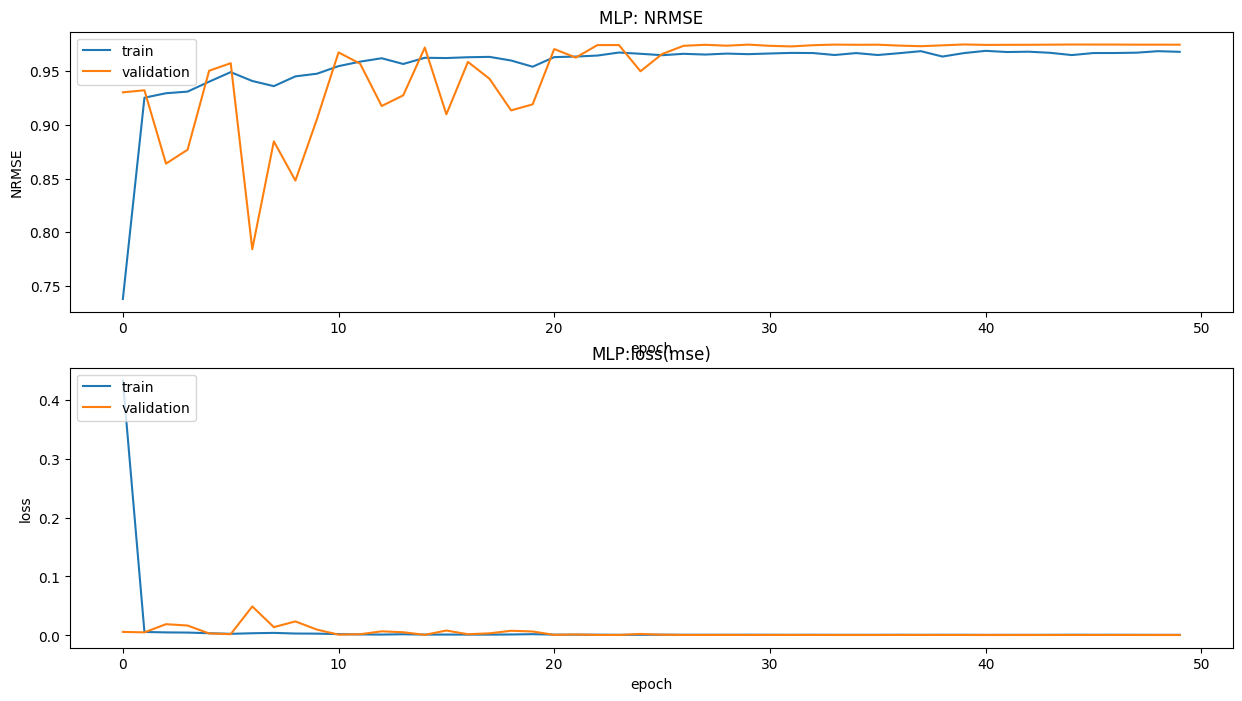

Training model : models/model_GRU_stock_IBOV_lookback_23
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Initing train fo model: GRU
Epoch 1/200
45/47 [===========================>..] - ETA: 0s - loss: 0.0141 - NRMSE: 0.9100
Epoch 1: val_loss improved from inf to 0.00096, saving model to models\model_GRU_stock_IBOV_lookback_23
INFO:tensorflow:Assets written to: models\model_GRU_stock_IBOV_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_GRU_stock_IBOV_lookback_23\assets


47/47 [==============================] - 8s 98ms/step - loss: 0.0139 - NRMSE: 0.9117 - val_loss: 9.6325e-04 - val_NRMSE: 0.9709 - lr: 0.0500
Epoch 2/200
45/47 [===========================>..] - ETA: 0s - loss: 0.0024 - NRMSE: 0.9522
Epoch 2: val_loss did not improve from 0.00096
47/47 [==============================] - 1s 19ms/step - loss: 0.0024 - NRMSE: 0.9519 - val_loss: 0.0016 - val_NRMSE: 0.9604 - lr: 0.0500
Epoch 3/200
44/47 [===========================>..] - ETA: 0s - loss: 0.0023 - NRMSE: 0.9531
Epoch 3: val_loss improved from 0.00096 to 0.00038, saving model to models\model_GRU_stock_IBOV_lookback_23
INFO:tensorflow:Assets written to: models\model_GRU_stock_IBOV_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_GRU_stock_IBOV_lookback_23\assets


47/47 [==============================] - 5s 98ms/step - loss: 0.0023 - NRMSE: 0.9539 - val_loss: 3.7783e-04 - val_NRMSE: 0.9829 - lr: 0.0500
Epoch 4/200
44/47 [===========================>..] - ETA: 0s - loss: 0.0022 - NRMSE: 0.9545
Epoch 4: val_loss did not improve from 0.00038
47/47 [==============================] - 1s 18ms/step - loss: 0.0022 - NRMSE: 0.9553 - val_loss: 4.7398e-04 - val_NRMSE: 0.9798 - lr: 0.0500
Epoch 5/200
45/47 [===========================>..] - ETA: 0s - loss: 0.0023 - NRMSE: 0.9534
Epoch 5: val_loss did not improve from 0.00038
47/47 [==============================] - 1s 18ms/step - loss: 0.0023 - NRMSE: 0.9536 - val_loss: 0.0032 - val_NRMSE: 0.9441 - lr: 0.0500
Epoch 6/200
44/47 [===========================>..] - ETA: 0s - loss: 0.0020 - NRMSE: 0.9566
Epoch 6: val_loss did not improve from 0.00038
47/47 [==============================] - 1s 17ms/step - loss: 0.0019 - NRMSE: 0.9577 - val_loss: 0.0022 - val_NRMSE: 0.9536 - lr: 0.0500
Epoch 7/200
45/47 [========

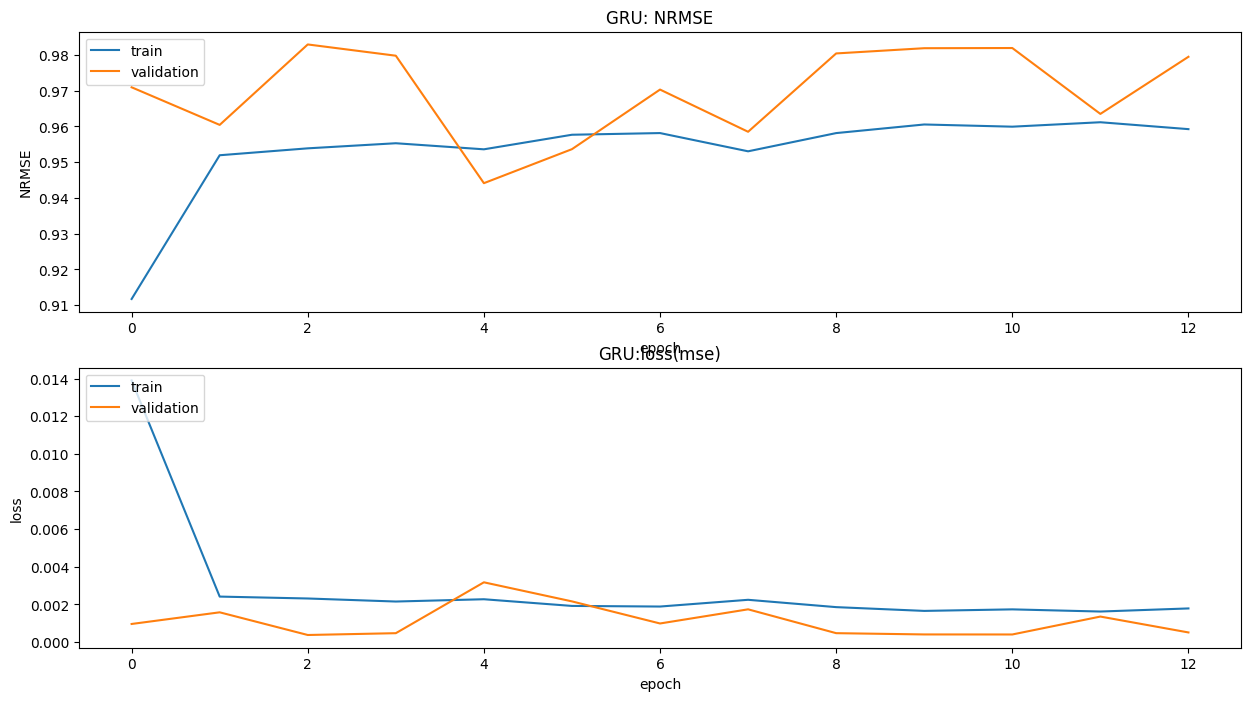

Training model : models/model_CNN_LSTM_stock_IBOV_lookback_23
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Initing train fo model: CNN_LSTM
Epoch 1/200
36/47 [=====================>........] - ETA: 0s - loss: 1.0167 - NRMSE: 0.5723
Epoch 1: val_loss improved from inf to 0.00521, saving model to models\model_CNN_LSTM_stock_IBOV_lookback_23
INFO:tensorflow:Assets written to: models\model_CNN_LSTM_stock_IBOV_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_CNN_LSTM_stock_IBOV_lookback_23\assets


47/47 [==============================] - 4s 55ms/step - loss: 0.7973 - NRMSE: 0.6503 - val_loss: 0.0052 - val_NRMSE: 0.9334 - lr: 0.0500
Epoch 2/200
37/47 [======================>.......] - ETA: 0s - loss: 0.0049 - NRMSE: 0.9314
Epoch 2: val_loss improved from 0.00521 to 0.00472, saving model to models\model_CNN_LSTM_stock_IBOV_lookback_23
INFO:tensorflow:Assets written to: models\model_CNN_LSTM_stock_IBOV_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_CNN_LSTM_stock_IBOV_lookback_23\assets


47/47 [==============================] - 2s 54ms/step - loss: 0.0044 - NRMSE: 0.9358 - val_loss: 0.0047 - val_NRMSE: 0.9362 - lr: 0.0500
Epoch 3/200
35/47 [=====================>........] - ETA: 0s - loss: 0.0017 - NRMSE: 0.9604
Epoch 3: val_loss did not improve from 0.00472
47/47 [==============================] - 0s 8ms/step - loss: 0.0016 - NRMSE: 0.9621 - val_loss: 0.0050 - val_NRMSE: 0.9389 - lr: 0.0500
Epoch 4/200
45/47 [===========================>..] - ETA: 0s - loss: 0.0014 - NRMSE: 0.9636
Epoch 4: val_loss did not improve from 0.00472
47/47 [==============================] - 0s 8ms/step - loss: 0.0014 - NRMSE: 0.9642 - val_loss: 0.0081 - val_NRMSE: 0.9159 - lr: 0.0500
Epoch 5/200
43/47 [==========================>...] - ETA: 0s - loss: 0.0013 - NRMSE: 0.9650 
Epoch 5: val_loss improved from 0.00472 to 0.00218, saving model to models\model_CNN_LSTM_stock_IBOV_lookback_23
INFO:tensorflow:Assets written to: models\model_CNN_LSTM_stock_IBOV_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_CNN_LSTM_stock_IBOV_lookback_23\assets


47/47 [==============================] - 2s 53ms/step - loss: 0.0013 - NRMSE: 0.9646 - val_loss: 0.0022 - val_NRMSE: 0.9648 - lr: 0.0500
Epoch 6/200
38/47 [=======================>......] - ETA: 0s - loss: 0.0014 - NRMSE: 0.9645
Epoch 6: val_loss did not improve from 0.00218
47/47 [==============================] - 0s 9ms/step - loss: 0.0013 - NRMSE: 0.9659 - val_loss: 0.0072 - val_NRMSE: 0.9203 - lr: 0.0500
Epoch 7/200
42/47 [=========================>....] - ETA: 0s - loss: 0.0014 - NRMSE: 0.9642
Epoch 7: val_loss did not improve from 0.00218
47/47 [==============================] - 0s 9ms/step - loss: 0.0013 - NRMSE: 0.9655 - val_loss: 0.0113 - val_NRMSE: 0.8952 - lr: 0.0500
Epoch 8/200
43/47 [==========================>...] - ETA: 0s - loss: 9.3805e-04 - NRMSE: 0.9702
Epoch 8: val_loss did not improve from 0.00218
47/47 [==============================] - 0s 8ms/step - loss: 9.2622e-04 - NRMSE: 0.9707 - val_loss: 0.0090 - val_NRMSE: 0.9067 - lr: 0.0500
Epoch 9/200
42/47 [===========

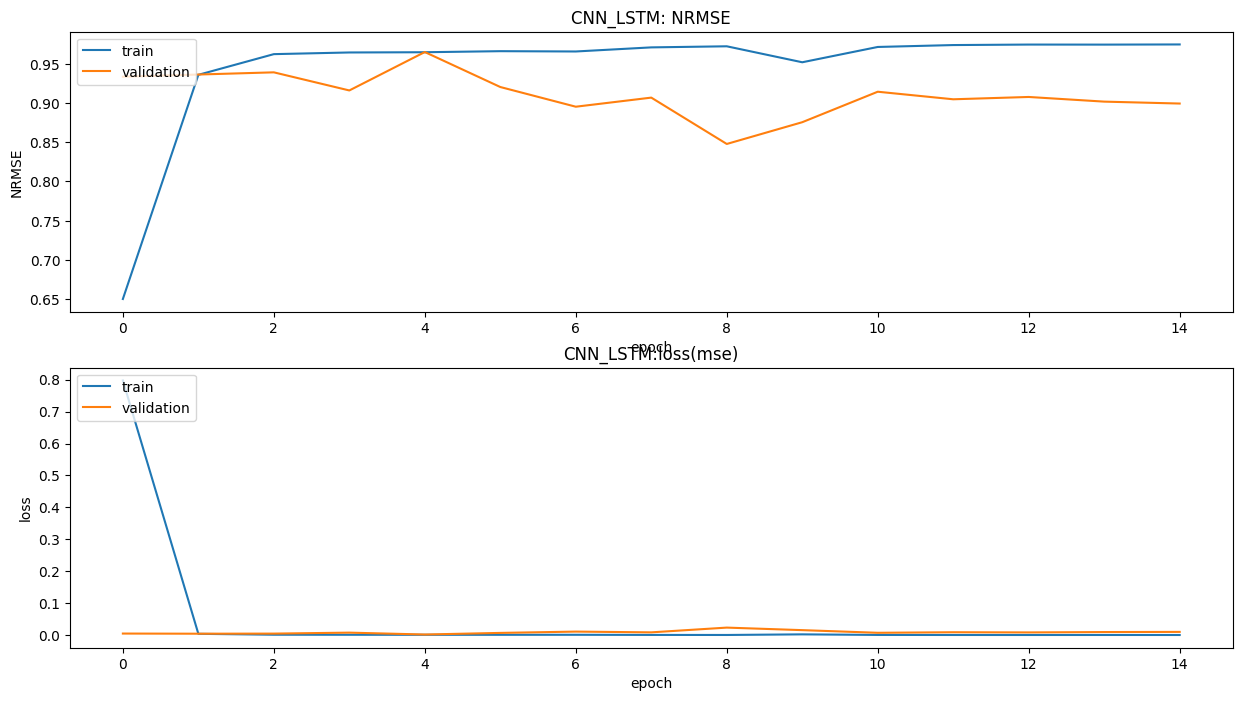

Training model : models/model_LSTM_stock_IBOV_lookback_23
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Initing train fo model: LSTM
Epoch 1/200
47/47 [==============================] - ETA: 0s - loss: 8938.0537 - NRMSE: -13.7969
Epoch 1: val_loss improved from inf to 1.07441, saving model to models\model_LSTM_stock_IBOV_lookback_23
INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


47/47 [==============================] - 8s 100ms/step - loss: 8938.0537 - NRMSE: -13.7969 - val_loss: 1.0744 - val_NRMSE: -0.0294 - lr: 0.0500
Epoch 2/200
47/47 [==============================] - ETA: 0s - loss: 0.3786 - NRMSE: 0.3857
Epoch 2: val_loss improved from 1.07441 to 0.84560, saving model to models\model_LSTM_stock_IBOV_lookback_23
INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


47/47 [==============================] - 4s 92ms/step - loss: 0.3786 - NRMSE: 0.3857 - val_loss: 0.8456 - val_NRMSE: 0.0877 - lr: 0.0500
Epoch 3/200
47/47 [==============================] - ETA: 0s - loss: 0.2653 - NRMSE: 0.4878
Epoch 3: val_loss improved from 0.84560 to 0.62942, saving model to models\model_LSTM_stock_IBOV_lookback_23
INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


47/47 [==============================] - 4s 89ms/step - loss: 0.2653 - NRMSE: 0.4878 - val_loss: 0.6294 - val_NRMSE: 0.2142 - lr: 0.0500
Epoch 4/200
44/47 [===========================>..] - ETA: 0s - loss: 0.1777 - NRMSE: 0.5810
Epoch 4: val_loss improved from 0.62942 to 0.45157, saving model to models\model_LSTM_stock_IBOV_lookback_23
INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


47/47 [==============================] - 5s 104ms/step - loss: 0.1750 - NRMSE: 0.5805 - val_loss: 0.4516 - val_NRMSE: 0.3361 - lr: 0.0500
Epoch 5/200
43/47 [==========================>...] - ETA: 0s - loss: 0.1120 - NRMSE: 0.6680
Epoch 5: val_loss improved from 0.45157 to 0.31620, saving model to models\model_LSTM_stock_IBOV_lookback_23
INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


47/47 [==============================] - 4s 90ms/step - loss: 0.1095 - NRMSE: 0.6778 - val_loss: 0.3162 - val_NRMSE: 0.4463 - lr: 0.0500
Epoch 6/200
45/47 [===========================>..] - ETA: 0s - loss: 0.0758 - NRMSE: 0.7283
Epoch 6: val_loss improved from 0.31620 to 0.23027, saving model to models\model_LSTM_stock_IBOV_lookback_23
INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


47/47 [==============================] - 4s 94ms/step - loss: 0.0756 - NRMSE: 0.7324 - val_loss: 0.2303 - val_NRMSE: 0.5294 - lr: 0.0500
Epoch 7/200
42/47 [=========================>....] - ETA: 0s - loss: 0.0538 - NRMSE: 0.7702
Epoch 7: val_loss improved from 0.23027 to 0.17603, saving model to models\model_LSTM_stock_IBOV_lookback_23
INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


47/47 [==============================] - 4s 85ms/step - loss: 0.0536 - NRMSE: 0.7746 - val_loss: 0.1760 - val_NRMSE: 0.5904 - lr: 0.0500
Epoch 8/200
43/47 [==========================>...] - ETA: 0s - loss: 0.0407 - NRMSE: 0.8007
Epoch 8: val_loss improved from 0.17603 to 0.14203, saving model to models\model_LSTM_stock_IBOV_lookback_23
INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


47/47 [==============================] - 4s 84ms/step - loss: 0.0407 - NRMSE: 0.8040 - val_loss: 0.1420 - val_NRMSE: 0.6336 - lr: 0.0500
Epoch 9/200
46/47 [============================>.] - ETA: 0s - loss: 0.0380 - NRMSE: 0.8073
Epoch 9: val_loss improved from 0.14203 to 0.12223, saving model to models\model_LSTM_stock_IBOV_lookback_23
INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


47/47 [==============================] - 5s 100ms/step - loss: 0.0380 - NRMSE: 0.8096 - val_loss: 0.1222 - val_NRMSE: 0.6613 - lr: 0.0500
Epoch 10/200
45/47 [===========================>..] - ETA: 0s - loss: 0.0353 - NRMSE: 0.8144
Epoch 10: val_loss improved from 0.12223 to 0.11236, saving model to models\model_LSTM_stock_IBOV_lookback_23
INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


47/47 [==============================] - 4s 87ms/step - loss: 0.0355 - NRMSE: 0.8164 - val_loss: 0.1124 - val_NRMSE: 0.6759 - lr: 0.0500
Epoch 11/200
42/47 [=========================>....] - ETA: 0s - loss: 0.0375 - NRMSE: 0.8090
Epoch 11: val_loss improved from 0.11236 to 0.10561, saving model to models\model_LSTM_stock_IBOV_lookback_23
INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


47/47 [==============================] - 4s 85ms/step - loss: 0.0375 - NRMSE: 0.8121 - val_loss: 0.1056 - val_NRMSE: 0.6863 - lr: 0.0500
Epoch 12/200
46/47 [============================>.] - ETA: 0s - loss: 0.0350 - NRMSE: 0.8155
Epoch 12: val_loss improved from 0.10561 to 0.10056, saving model to models\model_LSTM_stock_IBOV_lookback_23
INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


47/47 [==============================] - 6s 129ms/step - loss: 0.0350 - NRMSE: 0.8165 - val_loss: 0.1006 - val_NRMSE: 0.6943 - lr: 0.0500
Epoch 13/200
46/47 [============================>.] - ETA: 0s - loss: 0.0383 - NRMSE: 0.8061
Epoch 13: val_loss improved from 0.10056 to 0.09892, saving model to models\model_LSTM_stock_IBOV_lookback_23
INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


47/47 [==============================] - 4s 93ms/step - loss: 0.0382 - NRMSE: 0.8092 - val_loss: 0.0989 - val_NRMSE: 0.6969 - lr: 0.0500
Epoch 14/200
44/47 [===========================>..] - ETA: 0s - loss: 0.0351 - NRMSE: 0.8147
Epoch 14: val_loss improved from 0.09892 to 0.09735, saving model to models\model_LSTM_stock_IBOV_lookback_23
INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


47/47 [==============================] - 4s 93ms/step - loss: 0.0350 - NRMSE: 0.8155 - val_loss: 0.0974 - val_NRMSE: 0.6994 - lr: 0.0500
Epoch 15/200
46/47 [============================>.] - ETA: 0s - loss: 0.0362 - NRMSE: 0.8112
Epoch 15: val_loss improved from 0.09735 to 0.09700, saving model to models\model_LSTM_stock_IBOV_lookback_23
INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


47/47 [==============================] - 4s 91ms/step - loss: 0.0362 - NRMSE: 0.8132 - val_loss: 0.0970 - val_NRMSE: 0.7000 - lr: 0.0500
Epoch 16/200
45/47 [===========================>..] - ETA: 0s - loss: 0.0361 - NRMSE: 0.8117
Epoch 16: val_loss improved from 0.09700 to 0.09462, saving model to models\model_LSTM_stock_IBOV_lookback_23
INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


47/47 [==============================] - 4s 88ms/step - loss: 0.0360 - NRMSE: 0.8110 - val_loss: 0.0946 - val_NRMSE: 0.7039 - lr: 0.0500
Epoch 17/200
43/47 [==========================>...] - ETA: 0s - loss: 0.0355 - NRMSE: 0.8133
Epoch 17: val_loss improved from 0.09462 to 0.09453, saving model to models\model_LSTM_stock_IBOV_lookback_23
INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


47/47 [==============================] - 4s 92ms/step - loss: 0.0350 - NRMSE: 0.8145 - val_loss: 0.0945 - val_NRMSE: 0.7040 - lr: 0.0500
Epoch 18/200
42/47 [=========================>....] - ETA: 0s - loss: 0.0342 - NRMSE: 0.8170
Epoch 18: val_loss improved from 0.09453 to 0.09261, saving model to models\model_LSTM_stock_IBOV_lookback_23
INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


47/47 [==============================] - 4s 82ms/step - loss: 0.0334 - NRMSE: 0.8209 - val_loss: 0.0926 - val_NRMSE: 0.7072 - lr: 0.0500
Epoch 19/200
46/47 [============================>.] - ETA: 0s - loss: 0.0358 - NRMSE: 0.8121
Epoch 19: val_loss did not improve from 0.09261
47/47 [==============================] - 1s 16ms/step - loss: 0.0358 - NRMSE: 0.8128 - val_loss: 0.0943 - val_NRMSE: 0.7043 - lr: 0.0500
Epoch 20/200
44/47 [===========================>..] - ETA: 0s - loss: 0.0370 - NRMSE: 0.8095
Epoch 20: val_loss improved from 0.09261 to 0.09259, saving model to models\model_LSTM_stock_IBOV_lookback_23
INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


47/47 [==============================] - 4s 82ms/step - loss: 0.0368 - NRMSE: 0.8134 - val_loss: 0.0926 - val_NRMSE: 0.7072 - lr: 0.0500
Epoch 21/200
44/47 [===========================>..] - ETA: 0s - loss: 0.0366 - NRMSE: 0.8107
Epoch 21: val_loss improved from 0.09259 to 0.09213, saving model to models\model_LSTM_stock_IBOV_lookback_23
INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


47/47 [==============================] - 5s 100ms/step - loss: 0.0368 - NRMSE: 0.8121 - val_loss: 0.0921 - val_NRMSE: 0.7079 - lr: 0.0500
Epoch 22/200
44/47 [===========================>..] - ETA: 0s - loss: 0.0342 - NRMSE: 0.8169
Epoch 22: val_loss did not improve from 0.09213
47/47 [==============================] - 1s 22ms/step - loss: 0.0338 - NRMSE: 0.8218 - val_loss: 0.0928 - val_NRMSE: 0.7067 - lr: 0.0500
Epoch 23/200
45/47 [===========================>..] - ETA: 0s - loss: 0.0359 - NRMSE: 0.8118
Epoch 23: val_loss improved from 0.09213 to 0.09025, saving model to models\model_LSTM_stock_IBOV_lookback_23
INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


47/47 [==============================] - 4s 84ms/step - loss: 0.0360 - NRMSE: 0.8071 - val_loss: 0.0903 - val_NRMSE: 0.7111 - lr: 0.0500
Epoch 24/200
43/47 [==========================>...] - ETA: 0s - loss: 0.0329 - NRMSE: 0.8202
Epoch 24: val_loss improved from 0.09025 to 0.08991, saving model to models\model_LSTM_stock_IBOV_lookback_23
INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


47/47 [==============================] - 4s 85ms/step - loss: 0.0326 - NRMSE: 0.8196 - val_loss: 0.0899 - val_NRMSE: 0.7116 - lr: 0.0500
Epoch 25/200
47/47 [==============================] - ETA: 0s - loss: 0.0335 - NRMSE: 0.8205
Epoch 25: val_loss did not improve from 0.08991
47/47 [==============================] - 1s 17ms/step - loss: 0.0335 - NRMSE: 0.8205 - val_loss: 0.0927 - val_NRMSE: 0.7068 - lr: 0.0500
Epoch 26/200
45/47 [===========================>..] - ETA: 0s - loss: 0.0340 - NRMSE: 0.8166
Epoch 26: val_loss did not improve from 0.08991
47/47 [==============================] - 1s 18ms/step - loss: 0.0340 - NRMSE: 0.8194 - val_loss: 0.0919 - val_NRMSE: 0.7081 - lr: 0.0500
Epoch 27/200
45/47 [===========================>..] - ETA: 0s - loss: 0.0316 - NRMSE: 0.8238
Epoch 27: val_loss did not improve from 0.08991
47/47 [==============================] - 1s 17ms/step - loss: 0.0319 - NRMSE: 0.8141 - val_loss: 0.0904 - val_NRMSE: 0.7107 - lr: 0.0500
Epoch 28/200
47/47 [=========

INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


47/47 [==============================] - 4s 83ms/step - loss: 0.0331 - NRMSE: 0.8191 - val_loss: 0.0863 - val_NRMSE: 0.7176 - lr: 0.0500
Epoch 29/200
47/47 [==============================] - ETA: 0s - loss: 0.0323 - NRMSE: 0.8201
Epoch 29: val_loss did not improve from 0.08634
47/47 [==============================] - 1s 17ms/step - loss: 0.0323 - NRMSE: 0.8201 - val_loss: 0.0889 - val_NRMSE: 0.7131 - lr: 0.0500
Epoch 30/200
46/47 [============================>.] - ETA: 0s - loss: 0.0332 - NRMSE: 0.8199
Epoch 30: val_loss did not improve from 0.08634
47/47 [==============================] - 1s 17ms/step - loss: 0.0331 - NRMSE: 0.8208 - val_loss: 0.0878 - val_NRMSE: 0.7149 - lr: 0.0500
Epoch 31/200
43/47 [==========================>...] - ETA: 0s - loss: 0.0326 - NRMSE: 0.8203
Epoch 31: val_loss did not improve from 0.08634
47/47 [==============================] - 1s 17ms/step - loss: 0.0321 - NRMSE: 0.8204 - val_loss: 0.0885 - val_NRMSE: 0.7136 - lr: 0.0500
Epoch 32/200
45/47 [=========

INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


47/47 [==============================] - 4s 91ms/step - loss: 0.0324 - NRMSE: 0.8201 - val_loss: 0.0859 - val_NRMSE: 0.7181 - lr: 0.0500
Epoch 33/200
44/47 [===========================>..] - ETA: 0s - loss: 0.0335 - NRMSE: 0.8183
Epoch 33: val_loss did not improve from 0.08588
47/47 [==============================] - 1s 17ms/step - loss: 0.0332 - NRMSE: 0.8218 - val_loss: 0.0866 - val_NRMSE: 0.7168 - lr: 0.0500
Epoch 34/200
47/47 [==============================] - ETA: 0s - loss: 0.0316 - NRMSE: 0.8255
Epoch 34: val_loss improved from 0.08588 to 0.08531, saving model to models\model_LSTM_stock_IBOV_lookback_23
INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


47/47 [==============================] - 4s 81ms/step - loss: 0.0316 - NRMSE: 0.8255 - val_loss: 0.0853 - val_NRMSE: 0.7190 - lr: 0.0500
Epoch 35/200
45/47 [===========================>..] - ETA: 0s - loss: 0.0317 - NRMSE: 0.8229
Epoch 35: val_loss improved from 0.08531 to 0.08499, saving model to models\model_LSTM_stock_IBOV_lookback_23
INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


47/47 [==============================] - 4s 92ms/step - loss: 0.0318 - NRMSE: 0.8226 - val_loss: 0.0850 - val_NRMSE: 0.7196 - lr: 0.0500
Epoch 36/200
47/47 [==============================] - ETA: 0s - loss: 0.0317 - NRMSE: 0.8241
Epoch 36: val_loss did not improve from 0.08499
47/47 [==============================] - 1s 22ms/step - loss: 0.0317 - NRMSE: 0.8241 - val_loss: 0.0857 - val_NRMSE: 0.7183 - lr: 0.0500
Epoch 37/200
46/47 [============================>.] - ETA: 0s - loss: 0.0300 - NRMSE: 0.8280
Epoch 37: val_loss improved from 0.08499 to 0.08406, saving model to models\model_LSTM_stock_IBOV_lookback_23
INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


47/47 [==============================] - 4s 95ms/step - loss: 0.0300 - NRMSE: 0.8263 - val_loss: 0.0841 - val_NRMSE: 0.7211 - lr: 0.0500
Epoch 38/200
43/47 [==========================>...] - ETA: 0s - loss: 0.0323 - NRMSE: 0.8222
Epoch 38: val_loss did not improve from 0.08406
47/47 [==============================] - 1s 17ms/step - loss: 0.0327 - NRMSE: 0.8227 - val_loss: 0.0849 - val_NRMSE: 0.7197 - lr: 0.0500
Epoch 39/200
44/47 [===========================>..] - ETA: 0s - loss: 0.0318 - NRMSE: 0.8230
Epoch 39: val_loss improved from 0.08406 to 0.08209, saving model to models\model_LSTM_stock_IBOV_lookback_23
INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


47/47 [==============================] - 5s 105ms/step - loss: 0.0315 - NRMSE: 0.8266 - val_loss: 0.0821 - val_NRMSE: 0.7245 - lr: 0.0500
Epoch 40/200
45/47 [===========================>..] - ETA: 0s - loss: 0.0291 - NRMSE: 0.8307
Epoch 40: val_loss did not improve from 0.08209
47/47 [==============================] - 1s 18ms/step - loss: 0.0294 - NRMSE: 0.8316 - val_loss: 0.0821 - val_NRMSE: 0.7244 - lr: 0.0500
Epoch 41/200
46/47 [============================>.] - ETA: 0s - loss: 0.0318 - NRMSE: 0.8230
Epoch 41: val_loss improved from 0.08209 to 0.08093, saving model to models\model_LSTM_stock_IBOV_lookback_23
INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


47/47 [==============================] - 4s 91ms/step - loss: 0.0318 - NRMSE: 0.8232 - val_loss: 0.0809 - val_NRMSE: 0.7265 - lr: 0.0500
Epoch 42/200
45/47 [===========================>..] - ETA: 0s - loss: 0.0305 - NRMSE: 0.8262
Epoch 42: val_loss did not improve from 0.08093
47/47 [==============================] - 1s 17ms/step - loss: 0.0308 - NRMSE: 0.8261 - val_loss: 0.0827 - val_NRMSE: 0.7233 - lr: 0.0500
Epoch 43/200
45/47 [===========================>..] - ETA: 0s - loss: 0.0305 - NRMSE: 0.8268
Epoch 43: val_loss improved from 0.08093 to 0.07963, saving model to models\model_LSTM_stock_IBOV_lookback_23
INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


47/47 [==============================] - 4s 84ms/step - loss: 0.0302 - NRMSE: 0.8280 - val_loss: 0.0796 - val_NRMSE: 0.7287 - lr: 0.0500
Epoch 44/200
45/47 [===========================>..] - ETA: 0s - loss: 0.0311 - NRMSE: 0.8258
Epoch 44: val_loss improved from 0.07963 to 0.07854, saving model to models\model_LSTM_stock_IBOV_lookback_23
INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


47/47 [==============================] - 4s 91ms/step - loss: 0.0311 - NRMSE: 0.8250 - val_loss: 0.0785 - val_NRMSE: 0.7306 - lr: 0.0500
Epoch 45/200
43/47 [==========================>...] - ETA: 0s - loss: 0.0302 - NRMSE: 0.8275
Epoch 45: val_loss did not improve from 0.07854
47/47 [==============================] - 1s 17ms/step - loss: 0.0297 - NRMSE: 0.8297 - val_loss: 0.0801 - val_NRMSE: 0.7277 - lr: 0.0500
Epoch 46/200
45/47 [===========================>..] - ETA: 0s - loss: 0.0291 - NRMSE: 0.8317
Epoch 46: val_loss did not improve from 0.07854
47/47 [==============================] - 1s 17ms/step - loss: 0.0295 - NRMSE: 0.8308 - val_loss: 0.0803 - val_NRMSE: 0.7273 - lr: 0.0500
Epoch 47/200
45/47 [===========================>..] - ETA: 0s - loss: 0.0313 - NRMSE: 0.8251
Epoch 47: val_loss did not improve from 0.07854
47/47 [==============================] - 1s 18ms/step - loss: 0.0314 - NRMSE: 0.8249 - val_loss: 0.0798 - val_NRMSE: 0.7282 - lr: 0.0500
Epoch 48/200
43/47 [=========

INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


47/47 [==============================] - 5s 98ms/step - loss: 0.0308 - NRMSE: 0.8249 - val_loss: 0.0740 - val_NRMSE: 0.7387 - lr: 0.0500
Epoch 50/200
45/47 [===========================>..] - ETA: 0s - loss: 0.0297 - NRMSE: 0.8290
Epoch 50: val_loss did not improve from 0.07405
47/47 [==============================] - 1s 17ms/step - loss: 0.0295 - NRMSE: 0.8281 - val_loss: 0.0766 - val_NRMSE: 0.7339 - lr: 0.0500
Epoch 51/200
47/47 [==============================] - ETA: 0s - loss: 0.0297 - NRMSE: 0.8324
Epoch 51: val_loss did not improve from 0.07405
47/47 [==============================] - 1s 17ms/step - loss: 0.0297 - NRMSE: 0.8324 - val_loss: 0.0781 - val_NRMSE: 0.7310 - lr: 0.0500
Epoch 52/200
46/47 [============================>.] - ETA: 0s - loss: 0.0298 - NRMSE: 0.8285
Epoch 52: val_loss did not improve from 0.07405
47/47 [==============================] - 1s 17ms/step - loss: 0.0298 - NRMSE: 0.8315 - val_loss: 0.0744 - val_NRMSE: 0.7378 - lr: 0.0500
Epoch 53/200
45/47 [=========

INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


47/47 [==============================] - 4s 87ms/step - loss: 0.0281 - NRMSE: 0.8357 - val_loss: 0.0730 - val_NRMSE: 0.7405 - lr: 0.0500
Epoch 54/200
45/47 [===========================>..] - ETA: 0s - loss: 0.0291 - NRMSE: 0.8312
Epoch 54: val_loss did not improve from 0.07295
47/47 [==============================] - 1s 17ms/step - loss: 0.0292 - NRMSE: 0.8340 - val_loss: 0.0731 - val_NRMSE: 0.7402 - lr: 0.0500
Epoch 55/200
45/47 [===========================>..] - ETA: 0s - loss: 0.0278 - NRMSE: 0.8347
Epoch 55: val_loss improved from 0.07295 to 0.07259, saving model to models\model_LSTM_stock_IBOV_lookback_23
INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


47/47 [==============================] - 5s 114ms/step - loss: 0.0278 - NRMSE: 0.8366 - val_loss: 0.0726 - val_NRMSE: 0.7411 - lr: 0.0500
Epoch 56/200
47/47 [==============================] - ETA: 0s - loss: 0.0285 - NRMSE: 0.8367
Epoch 56: val_loss did not improve from 0.07259
47/47 [==============================] - 1s 16ms/step - loss: 0.0285 - NRMSE: 0.8367 - val_loss: 0.0737 - val_NRMSE: 0.7389 - lr: 0.0500
Epoch 57/200
47/47 [==============================] - ETA: 0s - loss: 0.0266 - NRMSE: 0.8402
Epoch 57: val_loss did not improve from 0.07259
47/47 [==============================] - 1s 20ms/step - loss: 0.0266 - NRMSE: 0.8402 - val_loss: 0.0731 - val_NRMSE: 0.7399 - lr: 0.0500
Epoch 58/200
46/47 [============================>.] - ETA: 0s - loss: 0.0296 - NRMSE: 0.8296
Epoch 58: val_loss improved from 0.07259 to 0.07090, saving model to models\model_LSTM_stock_IBOV_lookback_23
INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


47/47 [==============================] - 4s 85ms/step - loss: 0.0296 - NRMSE: 0.8314 - val_loss: 0.0709 - val_NRMSE: 0.7441 - lr: 0.0500
Epoch 59/200
43/47 [==========================>...] - ETA: 0s - loss: 0.0285 - NRMSE: 0.8330
Epoch 59: val_loss improved from 0.07090 to 0.07027, saving model to models\model_LSTM_stock_IBOV_lookback_23
INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


47/47 [==============================] - 5s 119ms/step - loss: 0.0281 - NRMSE: 0.8363 - val_loss: 0.0703 - val_NRMSE: 0.7452 - lr: 0.0500
Epoch 60/200
46/47 [============================>.] - ETA: 0s - loss: 0.0295 - NRMSE: 0.8300
Epoch 60: val_loss improved from 0.07027 to 0.06854, saving model to models\model_LSTM_stock_IBOV_lookback_23
INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


47/47 [==============================] - 5s 98ms/step - loss: 0.0295 - NRMSE: 0.8285 - val_loss: 0.0685 - val_NRMSE: 0.7485 - lr: 0.0500
Epoch 61/200
44/47 [===========================>..] - ETA: 0s - loss: 0.0275 - NRMSE: 0.8361
Epoch 61: val_loss did not improve from 0.06854
47/47 [==============================] - 1s 17ms/step - loss: 0.0276 - NRMSE: 0.8341 - val_loss: 0.0698 - val_NRMSE: 0.7461 - lr: 0.0500
Epoch 62/200
45/47 [===========================>..] - ETA: 0s - loss: 0.0262 - NRMSE: 0.8397
Epoch 62: val_loss did not improve from 0.06854
47/47 [==============================] - 1s 17ms/step - loss: 0.0261 - NRMSE: 0.8411 - val_loss: 0.0702 - val_NRMSE: 0.7451 - lr: 0.0500
Epoch 63/200
45/47 [===========================>..] - ETA: 0s - loss: 0.0282 - NRMSE: 0.8345
Epoch 63: val_loss did not improve from 0.06854
47/47 [==============================] - 1s 17ms/step - loss: 0.0282 - NRMSE: 0.8373 - val_loss: 0.0697 - val_NRMSE: 0.7461 - lr: 0.0500
Epoch 64/200
45/47 [=========

INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


47/47 [==============================] - 4s 76ms/step - loss: 0.0276 - NRMSE: 0.8351 - val_loss: 0.0678 - val_NRMSE: 0.7496 - lr: 0.0500
Epoch 65/200
46/47 [============================>.] - ETA: 0s - loss: 0.0296 - NRMSE: 0.8293
Epoch 65: val_loss improved from 0.06782 to 0.06664, saving model to models\model_LSTM_stock_IBOV_lookback_23
INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


47/47 [==============================] - 4s 87ms/step - loss: 0.0297 - NRMSE: 0.8266 - val_loss: 0.0666 - val_NRMSE: 0.7519 - lr: 0.0500
Epoch 66/200
47/47 [==============================] - ETA: 0s - loss: 0.0250 - NRMSE: 0.8462
Epoch 66: val_loss improved from 0.06664 to 0.06476, saving model to models\model_LSTM_stock_IBOV_lookback_23
INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


47/47 [==============================] - 4s 92ms/step - loss: 0.0250 - NRMSE: 0.8462 - val_loss: 0.0648 - val_NRMSE: 0.7556 - lr: 0.0500
Epoch 67/200
46/47 [============================>.] - ETA: 0s - loss: 0.0251 - NRMSE: 0.8438
Epoch 67: val_loss did not improve from 0.06476
47/47 [==============================] - 1s 18ms/step - loss: 0.0251 - NRMSE: 0.8465 - val_loss: 0.0656 - val_NRMSE: 0.7539 - lr: 0.0500
Epoch 68/200
43/47 [==========================>...] - ETA: 0s - loss: 0.0269 - NRMSE: 0.8375
Epoch 68: val_loss did not improve from 0.06476
47/47 [==============================] - 1s 18ms/step - loss: 0.0271 - NRMSE: 0.8391 - val_loss: 0.0651 - val_NRMSE: 0.7548 - lr: 0.0500
Epoch 69/200
43/47 [==========================>...] - ETA: 0s - loss: 0.0280 - NRMSE: 0.8344
Epoch 69: val_loss improved from 0.06476 to 0.06308, saving model to models\model_LSTM_stock_IBOV_lookback_23
INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


47/47 [==============================] - 4s 85ms/step - loss: 0.0279 - NRMSE: 0.8370 - val_loss: 0.0631 - val_NRMSE: 0.7587 - lr: 0.0500
Epoch 70/200
46/47 [============================>.] - ETA: 0s - loss: 0.0255 - NRMSE: 0.8421
Epoch 70: val_loss improved from 0.06308 to 0.06276, saving model to models\model_LSTM_stock_IBOV_lookback_23
INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


47/47 [==============================] - 6s 119ms/step - loss: 0.0255 - NRMSE: 0.8454 - val_loss: 0.0628 - val_NRMSE: 0.7592 - lr: 0.0500
Epoch 71/200
44/47 [===========================>..] - ETA: 0s - loss: 0.0248 - NRMSE: 0.8438
Epoch 71: val_loss improved from 0.06276 to 0.06192, saving model to models\model_LSTM_stock_IBOV_lookback_23
INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


47/47 [==============================] - 5s 99ms/step - loss: 0.0251 - NRMSE: 0.8445 - val_loss: 0.0619 - val_NRMSE: 0.7609 - lr: 0.0500
Epoch 72/200
47/47 [==============================] - ETA: 0s - loss: 0.0262 - NRMSE: 0.8428
Epoch 72: val_loss improved from 0.06192 to 0.05973, saving model to models\model_LSTM_stock_IBOV_lookback_23
INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


47/47 [==============================] - 4s 77ms/step - loss: 0.0262 - NRMSE: 0.8428 - val_loss: 0.0597 - val_NRMSE: 0.7653 - lr: 0.0500
Epoch 73/200
47/47 [==============================] - ETA: 0s - loss: 0.0237 - NRMSE: 0.8499
Epoch 73: val_loss did not improve from 0.05973
47/47 [==============================] - 1s 16ms/step - loss: 0.0237 - NRMSE: 0.8499 - val_loss: 0.0602 - val_NRMSE: 0.7643 - lr: 0.0500
Epoch 74/200
43/47 [==========================>...] - ETA: 0s - loss: 0.0243 - NRMSE: 0.8454
Epoch 74: val_loss did not improve from 0.05973
47/47 [==============================] - 1s 15ms/step - loss: 0.0243 - NRMSE: 0.8422 - val_loss: 0.0602 - val_NRMSE: 0.7640 - lr: 0.0500
Epoch 75/200
45/47 [===========================>..] - ETA: 0s - loss: 0.0263 - NRMSE: 0.8402
Epoch 75: val_loss improved from 0.05973 to 0.05708, saving model to models\model_LSTM_stock_IBOV_lookback_23
INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


47/47 [==============================] - 4s 81ms/step - loss: 0.0263 - NRMSE: 0.8427 - val_loss: 0.0571 - val_NRMSE: 0.7706 - lr: 0.0500
Epoch 76/200
44/47 [===========================>..] - ETA: 0s - loss: 0.0237 - NRMSE: 0.8475
Epoch 76: val_loss did not improve from 0.05708
47/47 [==============================] - 1s 16ms/step - loss: 0.0235 - NRMSE: 0.8490 - val_loss: 0.0581 - val_NRMSE: 0.7684 - lr: 0.0500
Epoch 77/200
42/47 [=========================>....] - ETA: 0s - loss: 0.0257 - NRMSE: 0.8413
Epoch 77: val_loss improved from 0.05708 to 0.05679, saving model to models\model_LSTM_stock_IBOV_lookback_23
INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


47/47 [==============================] - 4s 77ms/step - loss: 0.0253 - NRMSE: 0.8444 - val_loss: 0.0568 - val_NRMSE: 0.7710 - lr: 0.0500
Epoch 78/200
46/47 [============================>.] - ETA: 0s - loss: 0.0251 - NRMSE: 0.8437
Epoch 78: val_loss improved from 0.05679 to 0.05476, saving model to models\model_LSTM_stock_IBOV_lookback_23
INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


47/47 [==============================] - 3s 74ms/step - loss: 0.0251 - NRMSE: 0.8426 - val_loss: 0.0548 - val_NRMSE: 0.7753 - lr: 0.0500
Epoch 79/200
46/47 [============================>.] - ETA: 0s - loss: 0.0258 - NRMSE: 0.8413
Epoch 79: val_loss improved from 0.05476 to 0.05470, saving model to models\model_LSTM_stock_IBOV_lookback_23
INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


47/47 [==============================] - 3s 70ms/step - loss: 0.0258 - NRMSE: 0.8434 - val_loss: 0.0547 - val_NRMSE: 0.7753 - lr: 0.0500
Epoch 80/200
47/47 [==============================] - ETA: 0s - loss: 0.0229 - NRMSE: 0.8505
Epoch 80: val_loss improved from 0.05470 to 0.05422, saving model to models\model_LSTM_stock_IBOV_lookback_23
INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


47/47 [==============================] - 3s 66ms/step - loss: 0.0229 - NRMSE: 0.8505 - val_loss: 0.0542 - val_NRMSE: 0.7763 - lr: 0.0500
Epoch 81/200
46/47 [============================>.] - ETA: 0s - loss: 0.0247 - NRMSE: 0.8452
Epoch 81: val_loss improved from 0.05422 to 0.05288, saving model to models\model_LSTM_stock_IBOV_lookback_23
INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


47/47 [==============================] - 3s 76ms/step - loss: 0.0247 - NRMSE: 0.8472 - val_loss: 0.0529 - val_NRMSE: 0.7791 - lr: 0.0500
Epoch 82/200
46/47 [============================>.] - ETA: 0s - loss: 0.0248 - NRMSE: 0.8440
Epoch 82: val_loss did not improve from 0.05288
47/47 [==============================] - 1s 15ms/step - loss: 0.0248 - NRMSE: 0.8447 - val_loss: 0.0530 - val_NRMSE: 0.7788 - lr: 0.0500
Epoch 83/200
43/47 [==========================>...] - ETA: 0s - loss: 0.0243 - NRMSE: 0.8454
Epoch 83: val_loss improved from 0.05288 to 0.05152, saving model to models\model_LSTM_stock_IBOV_lookback_23
INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


47/47 [==============================] - 5s 102ms/step - loss: 0.0240 - NRMSE: 0.8454 - val_loss: 0.0515 - val_NRMSE: 0.7820 - lr: 0.0500
Epoch 84/200
44/47 [===========================>..] - ETA: 0s - loss: 0.0237 - NRMSE: 0.8479
Epoch 84: val_loss improved from 0.05152 to 0.05140, saving model to models\model_LSTM_stock_IBOV_lookback_23
INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


47/47 [==============================] - 4s 78ms/step - loss: 0.0241 - NRMSE: 0.8465 - val_loss: 0.0514 - val_NRMSE: 0.7821 - lr: 0.0500
Epoch 85/200
45/47 [===========================>..] - ETA: 0s - loss: 0.0233 - NRMSE: 0.8487
Epoch 85: val_loss improved from 0.05140 to 0.04999, saving model to models\model_LSTM_stock_IBOV_lookback_23
INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


47/47 [==============================] - 4s 81ms/step - loss: 0.0231 - NRMSE: 0.8495 - val_loss: 0.0500 - val_NRMSE: 0.7852 - lr: 0.0500
Epoch 86/200
45/47 [===========================>..] - ETA: 0s - loss: 0.0228 - NRMSE: 0.8503
Epoch 86: val_loss improved from 0.04999 to 0.04996, saving model to models\model_LSTM_stock_IBOV_lookback_23
INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


47/47 [==============================] - 4s 86ms/step - loss: 0.0226 - NRMSE: 0.8507 - val_loss: 0.0500 - val_NRMSE: 0.7852 - lr: 0.0500
Epoch 87/200
46/47 [============================>.] - ETA: 0s - loss: 0.0232 - NRMSE: 0.8493
Epoch 87: val_loss improved from 0.04996 to 0.04941, saving model to models\model_LSTM_stock_IBOV_lookback_23
INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


47/47 [==============================] - 3s 67ms/step - loss: 0.0232 - NRMSE: 0.8503 - val_loss: 0.0494 - val_NRMSE: 0.7863 - lr: 0.0500
Epoch 88/200
45/47 [===========================>..] - ETA: 0s - loss: 0.0214 - NRMSE: 0.8551
Epoch 88: val_loss improved from 0.04941 to 0.04792, saving model to models\model_LSTM_stock_IBOV_lookback_23
INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


47/47 [==============================] - 3s 68ms/step - loss: 0.0212 - NRMSE: 0.8557 - val_loss: 0.0479 - val_NRMSE: 0.7897 - lr: 0.0500
Epoch 89/200
46/47 [============================>.] - ETA: 0s - loss: 0.0219 - NRMSE: 0.8535
Epoch 89: val_loss improved from 0.04792 to 0.04725, saving model to models\model_LSTM_stock_IBOV_lookback_23
INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


47/47 [==============================] - 3s 66ms/step - loss: 0.0219 - NRMSE: 0.8520 - val_loss: 0.0472 - val_NRMSE: 0.7911 - lr: 0.0500
Epoch 90/200
43/47 [==========================>...] - ETA: 0s - loss: 0.0214 - NRMSE: 0.8552
Epoch 90: val_loss improved from 0.04725 to 0.04684, saving model to models\model_LSTM_stock_IBOV_lookback_23
INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


47/47 [==============================] - 4s 78ms/step - loss: 0.0214 - NRMSE: 0.8568 - val_loss: 0.0468 - val_NRMSE: 0.7920 - lr: 0.0500
Epoch 91/200
46/47 [============================>.] - ETA: 0s - loss: 0.0206 - NRMSE: 0.8577
Epoch 91: val_loss improved from 0.04684 to 0.04535, saving model to models\model_LSTM_stock_IBOV_lookback_23
INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


47/47 [==============================] - 3s 71ms/step - loss: 0.0206 - NRMSE: 0.8585 - val_loss: 0.0454 - val_NRMSE: 0.7955 - lr: 0.0500
Epoch 92/200
46/47 [============================>.] - ETA: 0s - loss: 0.0226 - NRMSE: 0.8515
Epoch 92: val_loss improved from 0.04535 to 0.04457, saving model to models\model_LSTM_stock_IBOV_lookback_23
INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


47/47 [==============================] - 3s 70ms/step - loss: 0.0226 - NRMSE: 0.8529 - val_loss: 0.0446 - val_NRMSE: 0.7972 - lr: 0.0500
Epoch 93/200
44/47 [===========================>..] - ETA: 0s - loss: 0.0206 - NRMSE: 0.8585
Epoch 93: val_loss improved from 0.04457 to 0.04390, saving model to models\model_LSTM_stock_IBOV_lookback_23
INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


47/47 [==============================] - 3s 70ms/step - loss: 0.0204 - NRMSE: 0.8580 - val_loss: 0.0439 - val_NRMSE: 0.7987 - lr: 0.0500
Epoch 94/200
47/47 [==============================] - ETA: 0s - loss: 0.0217 - NRMSE: 0.8544
Epoch 94: val_loss improved from 0.04390 to 0.04334, saving model to models\model_LSTM_stock_IBOV_lookback_23
INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


47/47 [==============================] - 3s 73ms/step - loss: 0.0217 - NRMSE: 0.8544 - val_loss: 0.0433 - val_NRMSE: 0.8000 - lr: 0.0500
Epoch 95/200
47/47 [==============================] - ETA: 0s - loss: 0.0204 - NRMSE: 0.8553
Epoch 95: val_loss improved from 0.04334 to 0.04184, saving model to models\model_LSTM_stock_IBOV_lookback_23
INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


47/47 [==============================] - 3s 69ms/step - loss: 0.0204 - NRMSE: 0.8553 - val_loss: 0.0418 - val_NRMSE: 0.8035 - lr: 0.0500
Epoch 96/200
46/47 [============================>.] - ETA: 0s - loss: 0.0212 - NRMSE: 0.8560
Epoch 96: val_loss improved from 0.04184 to 0.03845, saving model to models\model_LSTM_stock_IBOV_lookback_23
INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


47/47 [==============================] - 3s 75ms/step - loss: 0.0212 - NRMSE: 0.8565 - val_loss: 0.0384 - val_NRMSE: 0.8120 - lr: 0.0500
Epoch 97/200
47/47 [==============================] - ETA: 0s - loss: 0.0201 - NRMSE: 0.8618
Epoch 97: val_loss did not improve from 0.03845
47/47 [==============================] - 1s 14ms/step - loss: 0.0201 - NRMSE: 0.8618 - val_loss: 0.0385 - val_NRMSE: 0.8118 - lr: 0.0500
Epoch 98/200
47/47 [==============================] - ETA: 0s - loss: 0.0192 - NRMSE: 0.8661
Epoch 98: val_loss improved from 0.03845 to 0.03770, saving model to models\model_LSTM_stock_IBOV_lookback_23
INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


47/47 [==============================] - 3s 66ms/step - loss: 0.0192 - NRMSE: 0.8661 - val_loss: 0.0377 - val_NRMSE: 0.8137 - lr: 0.0500
Epoch 99/200
44/47 [===========================>..] - ETA: 0s - loss: 0.0201 - NRMSE: 0.8603
Epoch 99: val_loss improved from 0.03770 to 0.03670, saving model to models\model_LSTM_stock_IBOV_lookback_23
INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


47/47 [==============================] - 4s 81ms/step - loss: 0.0204 - NRMSE: 0.8593 - val_loss: 0.0367 - val_NRMSE: 0.8162 - lr: 0.0500
Epoch 100/200
42/47 [=========================>....] - ETA: 0s - loss: 0.0209 - NRMSE: 0.8581
Epoch 100: val_loss improved from 0.03670 to 0.03634, saving model to models\model_LSTM_stock_IBOV_lookback_23
INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


47/47 [==============================] - 3s 68ms/step - loss: 0.0205 - NRMSE: 0.8601 - val_loss: 0.0363 - val_NRMSE: 0.8170 - lr: 0.0500
Epoch 101/200
43/47 [==========================>...] - ETA: 0s - loss: 0.0189 - NRMSE: 0.8647
Epoch 101: val_loss improved from 0.03634 to 0.03561, saving model to models\model_LSTM_stock_IBOV_lookback_23
INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


47/47 [==============================] - 5s 118ms/step - loss: 0.0194 - NRMSE: 0.8581 - val_loss: 0.0356 - val_NRMSE: 0.8188 - lr: 0.0500
Epoch 102/200
44/47 [===========================>..] - ETA: 0s - loss: 0.0194 - NRMSE: 0.8629
Epoch 102: val_loss improved from 0.03561 to 0.03318, saving model to models\model_LSTM_stock_IBOV_lookback_23
INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


47/47 [==============================] - 4s 95ms/step - loss: 0.0195 - NRMSE: 0.8644 - val_loss: 0.0332 - val_NRMSE: 0.8253 - lr: 0.0500
Epoch 103/200
44/47 [===========================>..] - ETA: 0s - loss: 0.0199 - NRMSE: 0.8602
Epoch 103: val_loss improved from 0.03318 to 0.03181, saving model to models\model_LSTM_stock_IBOV_lookback_23
INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


47/47 [==============================] - 4s 82ms/step - loss: 0.0197 - NRMSE: 0.8626 - val_loss: 0.0318 - val_NRMSE: 0.8291 - lr: 0.0500
Epoch 104/200
47/47 [==============================] - ETA: 0s - loss: 0.0188 - NRMSE: 0.8675
Epoch 104: val_loss did not improve from 0.03181
47/47 [==============================] - 1s 18ms/step - loss: 0.0188 - NRMSE: 0.8675 - val_loss: 0.0328 - val_NRMSE: 0.8261 - lr: 0.0500
Epoch 105/200
45/47 [===========================>..] - ETA: 0s - loss: 0.0192 - NRMSE: 0.8642
Epoch 105: val_loss improved from 0.03181 to 0.03164, saving model to models\model_LSTM_stock_IBOV_lookback_23
INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


47/47 [==============================] - 4s 77ms/step - loss: 0.0191 - NRMSE: 0.8630 - val_loss: 0.0316 - val_NRMSE: 0.8293 - lr: 0.0500
Epoch 106/200
43/47 [==========================>...] - ETA: 0s - loss: 0.0189 - NRMSE: 0.8658
Epoch 106: val_loss did not improve from 0.03164
47/47 [==============================] - 1s 15ms/step - loss: 0.0190 - NRMSE: 0.8681 - val_loss: 0.0318 - val_NRMSE: 0.8288 - lr: 0.0500
Epoch 107/200
45/47 [===========================>..] - ETA: 0s - loss: 0.0184 - NRMSE: 0.8660
Epoch 107: val_loss improved from 0.03164 to 0.02999, saving model to models\model_LSTM_stock_IBOV_lookback_23
INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


47/47 [==============================] - 3s 69ms/step - loss: 0.0185 - NRMSE: 0.8682 - val_loss: 0.0300 - val_NRMSE: 0.8338 - lr: 0.0500
Epoch 108/200
42/47 [=========================>....] - ETA: 0s - loss: 0.0168 - NRMSE: 0.8720
Epoch 108: val_loss improved from 0.02999 to 0.02900, saving model to models\model_LSTM_stock_IBOV_lookback_23
INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


47/47 [==============================] - 4s 84ms/step - loss: 0.0167 - NRMSE: 0.8724 - val_loss: 0.0290 - val_NRMSE: 0.8366 - lr: 0.0500
Epoch 109/200
46/47 [============================>.] - ETA: 0s - loss: 0.0171 - NRMSE: 0.8712
Epoch 109: val_loss improved from 0.02900 to 0.02877, saving model to models\model_LSTM_stock_IBOV_lookback_23
INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


47/47 [==============================] - 3s 75ms/step - loss: 0.0171 - NRMSE: 0.8690 - val_loss: 0.0288 - val_NRMSE: 0.8372 - lr: 0.0500
Epoch 110/200
47/47 [==============================] - ETA: 0s - loss: 0.0174 - NRMSE: 0.8708
Epoch 110: val_loss improved from 0.02877 to 0.02842, saving model to models\model_LSTM_stock_IBOV_lookback_23
INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


47/47 [==============================] - 3s 69ms/step - loss: 0.0174 - NRMSE: 0.8708 - val_loss: 0.0284 - val_NRMSE: 0.8381 - lr: 0.0500
Epoch 111/200
43/47 [==========================>...] - ETA: 0s - loss: 0.0189 - NRMSE: 0.8647
Epoch 111: val_loss improved from 0.02842 to 0.02685, saving model to models\model_LSTM_stock_IBOV_lookback_23
INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


47/47 [==============================] - 5s 99ms/step - loss: 0.0184 - NRMSE: 0.8679 - val_loss: 0.0268 - val_NRMSE: 0.8429 - lr: 0.0500
Epoch 112/200
46/47 [============================>.] - ETA: 0s - loss: 0.0181 - NRMSE: 0.8676
Epoch 112: val_loss improved from 0.02685 to 0.02599, saving model to models\model_LSTM_stock_IBOV_lookback_23
INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


47/47 [==============================] - 4s 86ms/step - loss: 0.0181 - NRMSE: 0.8689 - val_loss: 0.0260 - val_NRMSE: 0.8454 - lr: 0.0500
Epoch 113/200
45/47 [===========================>..] - ETA: 0s - loss: 0.0170 - NRMSE: 0.8725
Epoch 113: val_loss improved from 0.02599 to 0.02580, saving model to models\model_LSTM_stock_IBOV_lookback_23
INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


47/47 [==============================] - 3s 73ms/step - loss: 0.0169 - NRMSE: 0.8739 - val_loss: 0.0258 - val_NRMSE: 0.8459 - lr: 0.0500
Epoch 114/200
46/47 [============================>.] - ETA: 0s - loss: 0.0164 - NRMSE: 0.8739
Epoch 114: val_loss improved from 0.02580 to 0.02567, saving model to models\model_LSTM_stock_IBOV_lookback_23
INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


47/47 [==============================] - 4s 85ms/step - loss: 0.0164 - NRMSE: 0.8745 - val_loss: 0.0257 - val_NRMSE: 0.8462 - lr: 0.0500
Epoch 115/200
47/47 [==============================] - ETA: 0s - loss: 0.0160 - NRMSE: 0.8738
Epoch 115: val_loss improved from 0.02567 to 0.02428, saving model to models\model_LSTM_stock_IBOV_lookback_23
INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


47/47 [==============================] - 4s 80ms/step - loss: 0.0160 - NRMSE: 0.8738 - val_loss: 0.0243 - val_NRMSE: 0.8505 - lr: 0.0500
Epoch 116/200
47/47 [==============================] - ETA: 0s - loss: 0.0153 - NRMSE: 0.8807
Epoch 116: val_loss improved from 0.02428 to 0.02280, saving model to models\model_LSTM_stock_IBOV_lookback_23
INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


47/47 [==============================] - 4s 78ms/step - loss: 0.0153 - NRMSE: 0.8807 - val_loss: 0.0228 - val_NRMSE: 0.8551 - lr: 0.0500
Epoch 117/200
45/47 [===========================>..] - ETA: 0s - loss: 0.0170 - NRMSE: 0.8716
Epoch 117: val_loss improved from 0.02280 to 0.02257, saving model to models\model_LSTM_stock_IBOV_lookback_23
INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


47/47 [==============================] - 3s 66ms/step - loss: 0.0171 - NRMSE: 0.8738 - val_loss: 0.0226 - val_NRMSE: 0.8558 - lr: 0.0500
Epoch 118/200
42/47 [=========================>....] - ETA: 0s - loss: 0.0170 - NRMSE: 0.8716
Epoch 118: val_loss improved from 0.02257 to 0.02175, saving model to models\model_LSTM_stock_IBOV_lookback_23
INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


47/47 [==============================] - 3s 71ms/step - loss: 0.0167 - NRMSE: 0.8743 - val_loss: 0.0217 - val_NRMSE: 0.8585 - lr: 0.0500
Epoch 119/200
46/47 [============================>.] - ETA: 0s - loss: 0.0149 - NRMSE: 0.8802
Epoch 119: val_loss improved from 0.02175 to 0.02130, saving model to models\model_LSTM_stock_IBOV_lookback_23
INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


47/47 [==============================] - 3s 69ms/step - loss: 0.0149 - NRMSE: 0.8805 - val_loss: 0.0213 - val_NRMSE: 0.8599 - lr: 0.0500
Epoch 120/200
46/47 [============================>.] - ETA: 0s - loss: 0.0140 - NRMSE: 0.8829
Epoch 120: val_loss improved from 0.02130 to 0.02052, saving model to models\model_LSTM_stock_IBOV_lookback_23
INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


47/47 [==============================] - 7s 145ms/step - loss: 0.0140 - NRMSE: 0.8836 - val_loss: 0.0205 - val_NRMSE: 0.8626 - lr: 0.0500
Epoch 121/200
46/47 [============================>.] - ETA: 0s - loss: 0.0140 - NRMSE: 0.8835
Epoch 121: val_loss did not improve from 0.02052
47/47 [==============================] - 1s 28ms/step - loss: 0.0140 - NRMSE: 0.8834 - val_loss: 0.0212 - val_NRMSE: 0.8600 - lr: 0.0500
Epoch 122/200
46/47 [============================>.] - ETA: 0s - loss: 0.0143 - NRMSE: 0.8824
Epoch 122: val_loss improved from 0.02052 to 0.02024, saving model to models\model_LSTM_stock_IBOV_lookback_23
INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


47/47 [==============================] - 7s 143ms/step - loss: 0.0143 - NRMSE: 0.8846 - val_loss: 0.0202 - val_NRMSE: 0.8633 - lr: 0.0500
Epoch 123/200
46/47 [============================>.] - ETA: 0s - loss: 0.0144 - NRMSE: 0.8815
Epoch 123: val_loss improved from 0.02024 to 0.01874, saving model to models\model_LSTM_stock_IBOV_lookback_23
INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


47/47 [==============================] - 5s 117ms/step - loss: 0.0144 - NRMSE: 0.8830 - val_loss: 0.0187 - val_NRMSE: 0.8688 - lr: 0.0500
Epoch 124/200
47/47 [==============================] - ETA: 0s - loss: 0.0158 - NRMSE: 0.8783
Epoch 124: val_loss improved from 0.01874 to 0.01788, saving model to models\model_LSTM_stock_IBOV_lookback_23
INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


47/47 [==============================] - 6s 133ms/step - loss: 0.0158 - NRMSE: 0.8783 - val_loss: 0.0179 - val_NRMSE: 0.8719 - lr: 0.0500
Epoch 125/200
44/47 [===========================>..] - ETA: 0s - loss: 0.0157 - NRMSE: 0.8768
Epoch 125: val_loss improved from 0.01788 to 0.01727, saving model to models\model_LSTM_stock_IBOV_lookback_23
INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


47/47 [==============================] - 5s 119ms/step - loss: 0.0158 - NRMSE: 0.8767 - val_loss: 0.0173 - val_NRMSE: 0.8742 - lr: 0.0500
Epoch 126/200
45/47 [===========================>..] - ETA: 0s - loss: 0.0130 - NRMSE: 0.8882
Epoch 126: val_loss did not improve from 0.01727
47/47 [==============================] - 1s 22ms/step - loss: 0.0130 - NRMSE: 0.8870 - val_loss: 0.0183 - val_NRMSE: 0.8699 - lr: 0.0500
Epoch 127/200
47/47 [==============================] - ETA: 0s - loss: 0.0136 - NRMSE: 0.8858
Epoch 127: val_loss improved from 0.01727 to 0.01637, saving model to models\model_LSTM_stock_IBOV_lookback_23
INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


47/47 [==============================] - 6s 132ms/step - loss: 0.0136 - NRMSE: 0.8858 - val_loss: 0.0164 - val_NRMSE: 0.8775 - lr: 0.0500
Epoch 128/200
45/47 [===========================>..] - ETA: 0s - loss: 0.0140 - NRMSE: 0.8841
Epoch 128: val_loss improved from 0.01637 to 0.01580, saving model to models\model_LSTM_stock_IBOV_lookback_23
INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


47/47 [==============================] - 5s 119ms/step - loss: 0.0138 - NRMSE: 0.8849 - val_loss: 0.0158 - val_NRMSE: 0.8797 - lr: 0.0500
Epoch 129/200
44/47 [===========================>..] - ETA: 0s - loss: 0.0134 - NRMSE: 0.8864
Epoch 129: val_loss did not improve from 0.01580
47/47 [==============================] - 1s 24ms/step - loss: 0.0133 - NRMSE: 0.8878 - val_loss: 0.0159 - val_NRMSE: 0.8793 - lr: 0.0500
Epoch 130/200
45/47 [===========================>..] - ETA: 0s - loss: 0.0132 - NRMSE: 0.8872
Epoch 130: val_loss did not improve from 0.01580
47/47 [==============================] - 1s 25ms/step - loss: 0.0131 - NRMSE: 0.8895 - val_loss: 0.0158 - val_NRMSE: 0.8794 - lr: 0.0500
Epoch 131/200
45/47 [===========================>..] - ETA: 0s - loss: 0.0134 - NRMSE: 0.8867
Epoch 131: val_loss improved from 0.01580 to 0.01457, saving model to models\model_LSTM_stock_IBOV_lookback_23
INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


47/47 [==============================] - 7s 141ms/step - loss: 0.0136 - NRMSE: 0.8882 - val_loss: 0.0146 - val_NRMSE: 0.8846 - lr: 0.0500
Epoch 132/200
45/47 [===========================>..] - ETA: 0s - loss: 0.0128 - NRMSE: 0.8884
Epoch 132: val_loss improved from 0.01457 to 0.01436, saving model to models\model_LSTM_stock_IBOV_lookback_23
INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


47/47 [==============================] - 6s 122ms/step - loss: 0.0127 - NRMSE: 0.8885 - val_loss: 0.0144 - val_NRMSE: 0.8853 - lr: 0.0500
Epoch 133/200
46/47 [============================>.] - ETA: 0s - loss: 0.0132 - NRMSE: 0.8873
Epoch 133: val_loss improved from 0.01436 to 0.01371, saving model to models\model_LSTM_stock_IBOV_lookback_23
INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


47/47 [==============================] - 5s 103ms/step - loss: 0.0132 - NRMSE: 0.8874 - val_loss: 0.0137 - val_NRMSE: 0.8881 - lr: 0.0500
Epoch 134/200
47/47 [==============================] - ETA: 0s - loss: 0.0138 - NRMSE: 0.8864
Epoch 134: val_loss improved from 0.01371 to 0.01336, saving model to models\model_LSTM_stock_IBOV_lookback_23
INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


47/47 [==============================] - 5s 113ms/step - loss: 0.0138 - NRMSE: 0.8864 - val_loss: 0.0134 - val_NRMSE: 0.8895 - lr: 0.0500
Epoch 135/200
46/47 [============================>.] - ETA: 0s - loss: 0.0128 - NRMSE: 0.8884
Epoch 135: val_loss improved from 0.01336 to 0.01314, saving model to models\model_LSTM_stock_IBOV_lookback_23
INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


47/47 [==============================] - 6s 133ms/step - loss: 0.0128 - NRMSE: 0.8879 - val_loss: 0.0131 - val_NRMSE: 0.8904 - lr: 0.0500
Epoch 136/200
43/47 [==========================>...] - ETA: 0s - loss: 0.0132 - NRMSE: 0.8874
Epoch 136: val_loss improved from 0.01314 to 0.01213, saving model to models\model_LSTM_stock_IBOV_lookback_23
INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


47/47 [==============================] - 5s 99ms/step - loss: 0.0133 - NRMSE: 0.8886 - val_loss: 0.0121 - val_NRMSE: 0.8949 - lr: 0.0500
Epoch 137/200
47/47 [==============================] - ETA: 0s - loss: 0.0133 - NRMSE: 0.8878
Epoch 137: val_loss improved from 0.01213 to 0.01199, saving model to models\model_LSTM_stock_IBOV_lookback_23
INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


47/47 [==============================] - 4s 98ms/step - loss: 0.0133 - NRMSE: 0.8878 - val_loss: 0.0120 - val_NRMSE: 0.8955 - lr: 0.0500
Epoch 138/200
46/47 [============================>.] - ETA: 0s - loss: 0.0120 - NRMSE: 0.8930
Epoch 138: val_loss did not improve from 0.01199
47/47 [==============================] - 1s 18ms/step - loss: 0.0119 - NRMSE: 0.8939 - val_loss: 0.0121 - val_NRMSE: 0.8951 - lr: 0.0500
Epoch 139/200
46/47 [============================>.] - ETA: 0s - loss: 0.0117 - NRMSE: 0.8937
Epoch 139: val_loss improved from 0.01199 to 0.01157, saving model to models\model_LSTM_stock_IBOV_lookback_23
INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


47/47 [==============================] - 5s 107ms/step - loss: 0.0117 - NRMSE: 0.8954 - val_loss: 0.0116 - val_NRMSE: 0.8973 - lr: 0.0500
Epoch 140/200
44/47 [===========================>..] - ETA: 0s - loss: 0.0131 - NRMSE: 0.8871
Epoch 140: val_loss improved from 0.01157 to 0.01041, saving model to models\model_LSTM_stock_IBOV_lookback_23
INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


47/47 [==============================] - 6s 119ms/step - loss: 0.0130 - NRMSE: 0.8881 - val_loss: 0.0104 - val_NRMSE: 0.9030 - lr: 0.0500
Epoch 141/200
47/47 [==============================] - ETA: 0s - loss: 0.0132 - NRMSE: 0.8807
Epoch 141: val_loss improved from 0.01041 to 0.01004, saving model to models\model_LSTM_stock_IBOV_lookback_23
INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


47/47 [==============================] - 4s 87ms/step - loss: 0.0132 - NRMSE: 0.8807 - val_loss: 0.0100 - val_NRMSE: 0.9048 - lr: 0.0500
Epoch 142/200
44/47 [===========================>..] - ETA: 0s - loss: 0.0116 - NRMSE: 0.8946
Epoch 142: val_loss improved from 0.01004 to 0.00928, saving model to models\model_LSTM_stock_IBOV_lookback_23
INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


47/47 [==============================] - 6s 130ms/step - loss: 0.0117 - NRMSE: 0.8949 - val_loss: 0.0093 - val_NRMSE: 0.9083 - lr: 0.0500
Epoch 143/200
43/47 [==========================>...] - ETA: 0s - loss: 0.0133 - NRMSE: 0.8870
Epoch 143: val_loss improved from 0.00928 to 0.00888, saving model to models\model_LSTM_stock_IBOV_lookback_23
INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


47/47 [==============================] - 5s 113ms/step - loss: 0.0129 - NRMSE: 0.8909 - val_loss: 0.0089 - val_NRMSE: 0.9104 - lr: 0.0500
Epoch 144/200
47/47 [==============================] - ETA: 0s - loss: 0.0112 - NRMSE: 0.8970
Epoch 144: val_loss did not improve from 0.00888
47/47 [==============================] - 1s 21ms/step - loss: 0.0112 - NRMSE: 0.8970 - val_loss: 0.0092 - val_NRMSE: 0.9083 - lr: 0.0500
Epoch 145/200
45/47 [===========================>..] - ETA: 0s - loss: 0.0128 - NRMSE: 0.8885
Epoch 145: val_loss did not improve from 0.00888
47/47 [==============================] - 1s 21ms/step - loss: 0.0129 - NRMSE: 0.8906 - val_loss: 0.0091 - val_NRMSE: 0.9092 - lr: 0.0500
Epoch 146/200
47/47 [==============================] - ETA: 0s - loss: 0.0127 - NRMSE: 0.8901
Epoch 146: val_loss improved from 0.00888 to 0.00840, saving model to models\model_LSTM_stock_IBOV_lookback_23
INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


47/47 [==============================] - 15s 321ms/step - loss: 0.0127 - NRMSE: 0.8901 - val_loss: 0.0084 - val_NRMSE: 0.9130 - lr: 0.0500
Epoch 147/200
44/47 [===========================>..] - ETA: 0s - loss: 0.0100 - NRMSE: 0.9020
Epoch 147: val_loss did not improve from 0.00840
47/47 [==============================] - 1s 29ms/step - loss: 0.0101 - NRMSE: 0.9030 - val_loss: 0.0086 - val_NRMSE: 0.9118 - lr: 0.0500
Epoch 148/200
46/47 [============================>.] - ETA: 0s - loss: 0.0120 - NRMSE: 0.8921
Epoch 148: val_loss improved from 0.00840 to 0.00822, saving model to models\model_LSTM_stock_IBOV_lookback_23
INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


47/47 [==============================] - 11s 245ms/step - loss: 0.0120 - NRMSE: 0.8944 - val_loss: 0.0082 - val_NRMSE: 0.9137 - lr: 0.0500
Epoch 149/200
44/47 [===========================>..] - ETA: 0s - loss: 0.0124 - NRMSE: 0.8915
Epoch 149: val_loss did not improve from 0.00822
47/47 [==============================] - 1s 30ms/step - loss: 0.0124 - NRMSE: 0.8931 - val_loss: 0.0084 - val_NRMSE: 0.9126 - lr: 0.0500
Epoch 150/200
45/47 [===========================>..] - ETA: 0s - loss: 0.0105 - NRMSE: 0.9004
Epoch 150: val_loss did not improve from 0.00822
47/47 [==============================] - 2s 34ms/step - loss: 0.0104 - NRMSE: 0.9010 - val_loss: 0.0083 - val_NRMSE: 0.9129 - lr: 0.0500
Epoch 151/200
47/47 [==============================] - ETA: 0s - loss: 0.0114 - NRMSE: 0.8949
Epoch 151: val_loss improved from 0.00822 to 0.00798, saving model to models\model_LSTM_stock_IBOV_lookback_23
INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


47/47 [==============================] - 8s 174ms/step - loss: 0.0114 - NRMSE: 0.8949 - val_loss: 0.0080 - val_NRMSE: 0.9149 - lr: 0.0500
Epoch 152/200
44/47 [===========================>..] - ETA: 0s - loss: 0.0107 - NRMSE: 0.8988
Epoch 152: val_loss improved from 0.00798 to 0.00722, saving model to models\model_LSTM_stock_IBOV_lookback_23
INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


47/47 [==============================] - 5s 109ms/step - loss: 0.0111 - NRMSE: 0.8963 - val_loss: 0.0072 - val_NRMSE: 0.9194 - lr: 0.0500
Epoch 153/200
45/47 [===========================>..] - ETA: 0s - loss: 0.0105 - NRMSE: 0.8995
Epoch 153: val_loss improved from 0.00722 to 0.00685, saving model to models\model_LSTM_stock_IBOV_lookback_23
INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


47/47 [==============================] - 8s 166ms/step - loss: 0.0107 - NRMSE: 0.8939 - val_loss: 0.0069 - val_NRMSE: 0.9218 - lr: 0.0500
Epoch 154/200
46/47 [============================>.] - ETA: 0s - loss: 0.0110 - NRMSE: 0.8973
Epoch 154: val_loss improved from 0.00685 to 0.00650, saving model to models\model_LSTM_stock_IBOV_lookback_23
INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


47/47 [==============================] - 5s 104ms/step - loss: 0.0110 - NRMSE: 0.8991 - val_loss: 0.0065 - val_NRMSE: 0.9239 - lr: 0.0500
Epoch 155/200
44/47 [===========================>..] - ETA: 0s - loss: 0.0101 - NRMSE: 0.9017
Epoch 155: val_loss did not improve from 0.00650
47/47 [==============================] - 1s 18ms/step - loss: 0.0100 - NRMSE: 0.9036 - val_loss: 0.0068 - val_NRMSE: 0.9218 - lr: 0.0500
Epoch 156/200
46/47 [============================>.] - ETA: 0s - loss: 0.0104 - NRMSE: 0.9001
Epoch 156: val_loss did not improve from 0.00650
47/47 [==============================] - 1s 20ms/step - loss: 0.0104 - NRMSE: 0.9012 - val_loss: 0.0072 - val_NRMSE: 0.9194 - lr: 0.0500
Epoch 157/200
45/47 [===========================>..] - ETA: 0s - loss: 0.0108 - NRMSE: 0.8991
Epoch 157: val_loss did not improve from 0.00650
47/47 [==============================] - 1s 20ms/step - loss: 0.0109 - NRMSE: 0.8998 - val_loss: 0.0072 - val_NRMSE: 0.9193 - lr: 0.0500
Epoch 158/200
43/47 [=

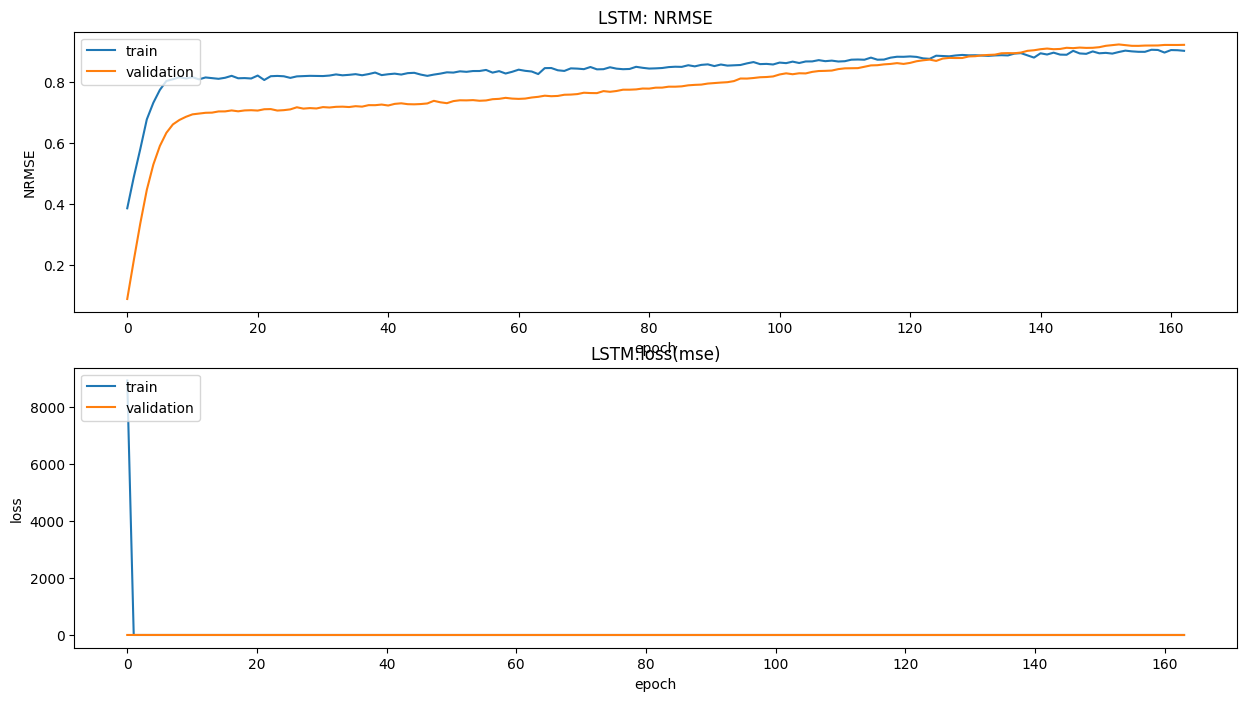

Training model : models/model_LSTM_AT_stock_IBOV_lookback_23
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Initing train fo model: LSTM_AT
Epoch 1/200
43/47 [==========================>...] - ETA: 0s - loss: 0.3197 - NRMSE: 0.6484
Epoch 1: val_loss improved from inf to 0.15228, saving model to models\model_LSTM_AT_stock_IBOV_lookback_23
INFO:tensorflow:Assets written to: models\model_LSTM_AT_stock_IBOV_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_LSTM_AT_stock_IBOV_lookback_23\assets


47/47 [==============================] - 9s 108ms/step - loss: 0.3013 - NRMSE: 0.6628 - val_loss: 0.1523 - val_NRMSE: 0.6279 - lr: 0.0500
Epoch 2/200
45/47 [===========================>..] - ETA: 0s - loss: 0.0441 - NRMSE: 0.7910
Epoch 2: val_loss did not improve from 0.15228
47/47 [==============================] - 1s 19ms/step - loss: 0.0437 - NRMSE: 0.7933 - val_loss: 0.1997 - val_NRMSE: 0.5691 - lr: 0.0500
Epoch 3/200
45/47 [===========================>..] - ETA: 0s - loss: 0.0437 - NRMSE: 0.7920
Epoch 3: val_loss did not improve from 0.15228
47/47 [==============================] - 1s 17ms/step - loss: 0.0434 - NRMSE: 0.7958 - val_loss: 0.1912 - val_NRMSE: 0.5790 - lr: 0.0500
Epoch 4/200
45/47 [===========================>..] - ETA: 0s - loss: 0.0433 - NRMSE: 0.7931
Epoch 4: val_loss did not improve from 0.15228
47/47 [==============================] - 1s 20ms/step - loss: 0.0433 - NRMSE: 0.7966 - val_loss: 0.1684 - val_NRMSE: 0.6069 - lr: 0.0500
Epoch 5/200
46/47 [===============

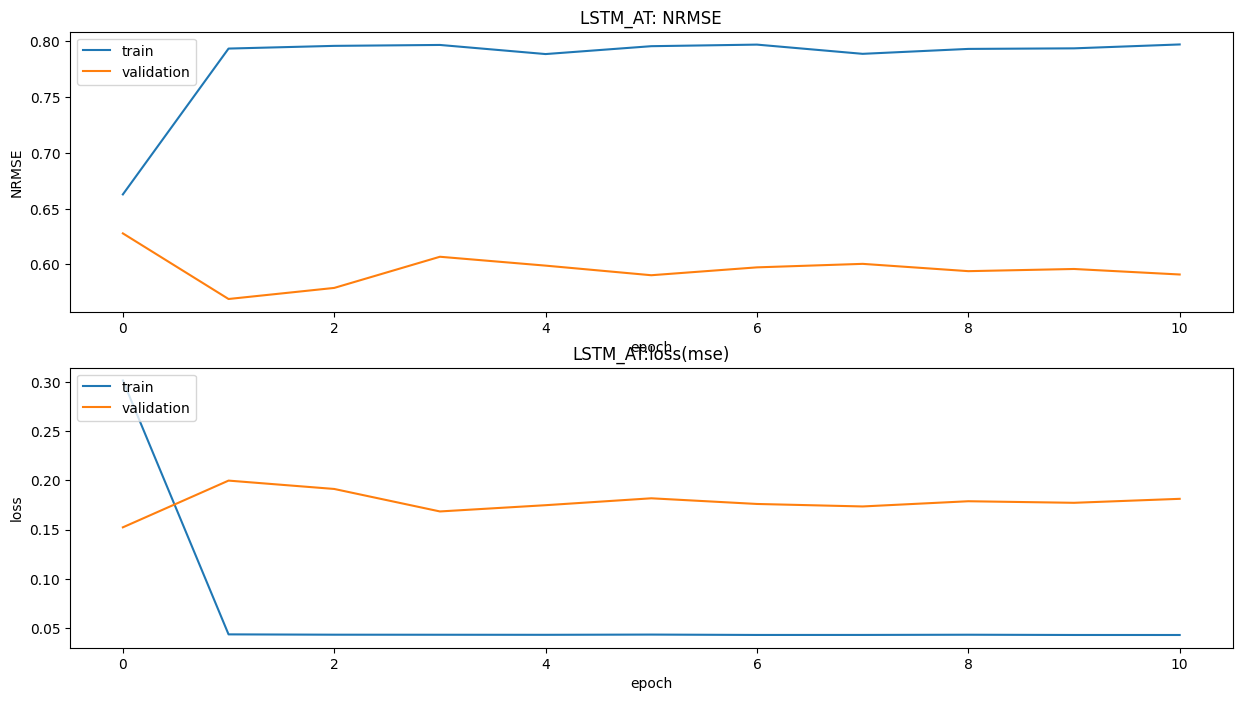

In [112]:
list_of_models=[model_MLP, model_GRU, model_CNN_LSTM, model_LSTM, model_LSTM_AT]
#list_of_models=[model_LSTM, model_LSTM_AT, model_GRU ]

for model in list_of_models:  
    optimizer = get_optimizer()
    csvLogger, model_checkpoint_callback  = checkpoints(model._name)
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=[NRMSE])

    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print(f'Initing train fo model: {model._name}')
    history=model.fit( x=X_train, y=y_train, epochs=200, batch_size=32, shuffle=True, validation_split=0.3 ,callbacks=[EarlyStopping, reduceLr, model_checkpoint_callback,csvLogger])

    history_metric=np.array(history.history['NRMSE']) 
    history_metric_val=np.array(history.history['val_NRMSE'])  

    plt.figure(1,figsize=(15,8))  
    # summarize history for accuracy  
    plt.subplot(211)  
    plt.plot(history_metric[history_metric>0]) 
    plt.plot(history_metric_val[history_metric_val>0])  
    plt.title(f'{model._name}: NRMSE')  
    plt.ylabel('NRMSE')  
    plt.xlabel('epoch')  
    plt.legend(['train', 'validation'], loc='upper left') 
    # summarize history for loss  
    plt.subplot(212)  
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])   
    plt.title(f'{model._name}:loss(mse)')  
    plt.ylabel('loss')  
    plt.xlabel('epoch')  
    plt.legend(['train', 'validation'], loc='upper left')  
    plt.show()  
    #history=model.fit( x=X_train, y=y_train, epochs=200, batch_size=256, shuffle=True, validation_split=0.1, callbacks=[EarlyStopping,model_checkpoint_callback, reduceLr])

In [113]:
from tensorflow import keras
trained_best_models={}
for model in list_of_models:
    checkpoint_filepath =f'models/model_{model._name}_stock_{ticker}_lookback_{lookback}'
    trained_best_models[f'{model._name}']=keras.models.load_model(checkpoint_filepath, custom_objects={'NRMSE':NRMSE})

In [114]:
trained_best_models

{'MLP': <keras.src.engine.functional.Functional at 0x19967245ae0>,
 'GRU': <keras.src.engine.functional.Functional at 0x1991dd6e1d0>,
 'CNN_LSTM': <keras.src.engine.sequential.Sequential at 0x1991a804160>,
 'LSTM': <keras.src.engine.functional.Functional at 0x19916b36620>,
 'LSTM_AT': <keras.src.engine.functional.Functional at 0x1991cad6680>}

In [115]:
def R2(y_true, y_pred): # squareds Pearson's correlation coef 
    SS_res =  np.sum(np.square( y_true-y_pred ))
    SS_tot = np.sum(np.square( y_true - np.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot) )

X_real, y_real = windowing(acoes_df['y'].values)
X_train_real,X_test_real, y_train_real, y_test_real,T_train,_=split_data(X_real,y_real,date_time, factor=0.85)

predictions=[]
for model_name in trained_best_models:
    y_pred=scaler.inverse_transform(trained_best_models[model_name].predict(X_test))
    r2_score= R2(y_test_real, y_pred )
    print(model_name,'NN R2:', r2_score)

    predictions+=[y_pred]
predictions=np.hstack(predictions)

12/12 [==============================] - 0s 2ms/step
MLP NN R2: 0.9443527273833752
12/12 [==============================] - 0s 6ms/step
GRU NN R2: 0.9728323332965374
12/12 [==============================] - 0s 3ms/step
CNN_LSTM NN R2: 0.920909084379673
12/12 [==============================] - 1s 6ms/step
LSTM NN R2: -0.22408652305603027
12/12 [==============================] - 0s 7ms/step
LSTM_AT NN R2: -26.50804901123047


In [116]:
y_test_real=np.hstack(y_test_real)
y_pred=np.hstack(y_pred)
y_train_real=np.hstack(y_train_real)

In [117]:
np.hstack(predictions)

array([113370.945, 113372.266, 111821.664, ..., 130301.94 , 115060.49 ,
        72169.914], dtype=float32)

In [118]:
trained_best_models.keys()

dict_keys(['MLP', 'GRU', 'CNN_LSTM', 'LSTM', 'LSTM_AT'])

In [119]:
import plotly.graph_objects as go

# Cria um gráfico de linha usando o Plotly
fig = go.Figure()

# Adiciona os valores reais ao gráfico
#fig.add_trace(go.Scatter(x=T_test, y=y_test_real, mode='lines', name='Real', line=dict(color='red')))
fig.add_trace(go.Scatter(x=T_train, y=y_train_real, mode='lines',name="Dados de Treino",line=dict(color='black')))
fig.add_trace(go.Scatter(x=T_test, y=y_test_real, mode='lines', name="Dados de Teste", line=dict(color='red')))

# Adiciona os valores preditos ao gráfico
colors=['blue', 'yellow', 'violet', 'yellowgreen', 'green']
for i in range(predictions.shape[1]):
    fig.add_trace(go.Scatter(x=T_test, y=predictions[:,i], mode='lines', name=f'{list(trained_best_models.keys())[i]}', line=dict(color=colors[i])))

# Configura o layout do gráfico
fig.update_layout(
    title=f'Resultado da predição com o modelo {model_name}',
    xaxis_title='Data',
    yaxis_title='Valor',
    showlegend=True,
    legend=dict(x=0, y=1, bgcolor='rgba(255, 255, 255, 0.5)')
)

# Exibe o gráfico
fig.show()


### Geração de valores para predições futuras

In [120]:
dias_antes=1
n_steps=7

print("Temos dados até o dia :",T_test.iloc[-1].date())

print("Estamos Fornecendo dados até o dia :",T_test.iloc[-1].date() -datetime.timedelta(days=dias_antes))

print("O modelo fará previsões até o dia: ",T_test.iloc[-1].date() -datetime.timedelta(days=dias_antes) + datetime.timedelta(days=n_steps))

Temos dados até o dia : 2024-02-27
Estamos Fornecendo dados até o dia : 2024-02-26
O modelo fará previsões até o dia:  2024-03-04


In [121]:
X_test[:-dias_antes,:]

array([[0.6440221 , 0.6612512 , 0.6732371 , ..., 0.7793417 , 0.7797657 ,
        0.78632224],
       [0.6612512 , 0.6732371 , 0.679111  , ..., 0.7797657 , 0.78632224,
        0.773571  ],
       [0.6732371 , 0.679111  , 0.66938996, ..., 0.78632224, 0.773571  ,
        0.7738192 ],
       ...,
       [0.92887056, 0.9321799 , 0.92148674, ..., 0.94665813, 0.9557587 ,
        0.9569583 ],
       [0.9321799 , 0.92148674, 0.9386641 , ..., 0.9557587 , 0.9569583 ,
        0.9591198 ],
       [0.92148674, 0.9386641 , 0.9340414 , ..., 0.9569583 , 0.9591198 ,
        0.950619  ]], dtype=float32)

In [122]:
new_predictions=[]
for model in list_of_models:
    # processo interativo para predição com o modelo de rede neural
    dias_antes=0
    n_steps=5

    if dias_antes == 0:
        NN_predictions=y_test.copy()
        X_inputs=X_test.copy()
        T_preds=T_test.values.copy()
    else :
        NN_predictions=y_test[:-dias_antes].copy()
        X_inputs=X_test[:-dias_antes,:].copy()
        T_preds=T_test.values[:-dias_antes].copy()
    continuous_time=T_preds.copy()
    for k in range(n_steps):
        
        # realizar a predição interativa com o modelo
        y_pred=model.predict(X_inputs[-1,:].reshape(1,-1))

        # guarda a predição do modelo para usa-la como entrada para a proxima predição
        NN_predictions=np.append(NN_predictions,[y_pred[0][0]])
        X_inputs=np.append(X_inputs,NN_predictions[-lookback:].reshape(1,-1),axis=0)

        # acrescenta um dia ao tempo atual 
        next_day=continuous_time[-1]+np.timedelta64(1,'D')
        continuous_time=np.append(continuous_time,next_day)    
        # verifica se o próximo dia é final de semana, se for pula até o dia útil 
        while next_day.astype('datetime64[D]').astype(datetime.datetime).isoweekday() > 5:
            # acrescenta um dia ao tempo atual 
            next_day=continuous_time[-1]+np.timedelta64(1,'D')
            continuous_time=np.append(continuous_time,next_day)

        T_preds=np.append(T_preds,next_day)
        
    new_predictions+=[scaler.inverse_transform(NN_predictions.reshape(-1,1))]
new_predictions=np.hstack(new_predictions)

1/1 [==============================] - 0s 38ms/step


In [123]:
# ARIMA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

combined_data_train=np.append(y_train,y_test[:-dias_antes])

try:
    if model_arima_fit is not None:
        print('Using ARIMA model')
except:
        model_arima = ARIMA(combined_data_train, order=(30, 2, 7))
        model_arima_fit = model_arima.fit()

        arima_predictions = model_arima_fit.predict(start=len(combined_data_train), end=len(combined_data_train)+n_steps)
        arima_predictions=np.hstack(scaler.inverse_transform(arima_predictions.reshape(-1,1)))
        arima_predictions.shape

Using ARIMA model


In [124]:
import plotly.graph_objects as go

# Cria um gráfico de linha usando o Plotly
fig = go.Figure()

fig.add_trace(go.Scatter(x=T_preds[-(n_steps+1):], y=arima_predictions, mode='lines', name="Predicted ARIMA", line=dict(color='green')))

# Adiciona os valores preditos ao gráfico
colors=['blue', 'tomato', 'violet', 'yellowgreen', 'green']
for i in range(new_predictions.shape[1]):
    fig.add_trace(go.Scatter(x=T_preds, y=new_predictions[:,i], mode='lines', name=f'{list(trained_best_models.keys())[i]}', line=dict(color=colors[i])))


# Adiciona os valores reais ao gráfico
fig.add_trace(go.Scatter(x=T_test.values, y=y_test_real, mode='lines', name=ticker, line=dict(color='black')))
# Configura o layout do gráfico
fig.update_layout(
    title=f'Resultado da predição com o modelo {model_name}',
    xaxis_title='Data',
    yaxis_title='Valor',
    showlegend=True,
    legend=dict(x=0, y=1, bgcolor='rgba(255, 255, 255, 0.5)')
)

# Exibe o gráfico
fig.show()

In [125]:
# modelos treinados 
[model.name for model in list_of_models]

['MLP', 'GRU', 'CNN_LSTM', 'LSTM', 'LSTM_AT']

In [126]:
model_idx=[model.name for model in list_of_models].index('GRU')

pred_data_df=pd.DataFrame({'Data': T_preds, 'pred': new_predictions[:,model_idx]})
# Calcular a variação percentual entre o preço de fechamento de um dia e o dia seguinte
pred_data_df['Variacao'] = ((pred_data_df['pred']-pred_data_df['pred'].shift(-1)) / pred_data_df['pred'])*100

# Definir a variável alvo com base na variação percentual
pred_data_df['Subida'] = pred_data_df['Variacao'].apply(lambda x: 1 if x > 0.2 else 0)
pred_data_df.tail(10)

,Data,pred,Variacao,Subida
368,2024-02-21,130031.992188,-0.160742,0
369,2024-02-22,130241.007812,0.631144,1
370,2024-02-23,129419.000000,-0.146816,0
371,2024-02-26,129609.007812,-1.604821,0
372,2024-02-27,131689.000000,1.266395,1
373,2024-02-28,130021.296875,-0.449506,0
374,2024-02-29,130605.750000,-0.320179,0
375,2024-03-01,131023.921875,-0.323832,0
376,2024-03-04,131448.218750,-0.333817,0
377,2024-03-05,131887.015625,NaN,0


In [127]:
result=pred_data_df.iloc[-2:-1,:]
result

,Data,pred,Variacao,Subida
376,2024-03-04,131448.21875,-0.333817,0


In [128]:
print("A previsão para o dia", result['Data'].item().date(),
      "é de", 'subida,' if result['Subida'].values==1 else "Descida,",
      f"de {np.round(result['Variacao'].values[0],2)}%",
      "o valor predito é de:", np.round(result['pred'].values[0],2) )


A previsão para o dia 2024-03-04 é de Descida, de -0.33000001311302185% o valor predito é de: 131448.22
